In [1]:
# ============================================================================
# PROJECT FOLDER STRUCTURE
# ============================================================================
# game-behavior-analytics/
# ├── data_analysis_notebook/
# │   └── analysis(PL+SM).ipynb
# ├── data/
# │   └── final_dataset.csv

# Change to the correct directory
%cd game-behavior-analytics/data_analysis_notebook/ 

/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook


/opt/anaconda3/envs/cheating_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
# ============================================================================
# PROJECT FOLDER STRUCTURE & DATA PREPARATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
df = pd.read_csv("../data/final_dataset.csv")

def categorize_cheating(rate):
    if rate == 0: return 0  # Non-cheater
    elif rate == 1: return 2  # Full cheater
    else: return 1  # Partial cheater

df['cheating_behavior'] = df['cheating_rate_main_round'].apply(categorize_cheating)
df['experience'] = (df['task_satisfaction'] + df['task_engagement']) / 2
df['performance'] = df['performance_score_including_cheated_words']
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept'])

# Prepare variables for analysis
concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])
concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

message_ids = df['motivational_message_id'].astype('category')
message_codes = message_ids.cat.codes.values

y_cheating = df['cheating_behavior'].values
y_performance = df['performance'].values
y_experience = df['experience'].values

# Control group baselines
control_data = df[df['concept'] == 'control']
control_cheating_counts = control_data['cheating_behavior'].value_counts().sort_index()
control_performance_mean = control_data['performance'].mean()
control_experience_mean = control_data['experience'].mean()

# Standardization
perf_std = np.std(y_performance)
exp_std = np.std(y_experience)

print(f"Dataset: {len(df)} participants")
print(f"Control: {len(control_data)}, Intervention: {len(df) - len(control_data)}")


# Calculate correlations by subgroup for model selection
corr_results = []
cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}

for group_name, group_data in [('Control', control_data), ('Intervention', df[df['concept'] != 'control'])]:
    for cheat_cat in [0, 1, 2]:
        subset = group_data[group_data['cheating_behavior'] == cheat_cat]
        if len(subset) >= 10:
            corr = subset[['performance', 'experience']].corr().iloc[0, 1]
        else:
            corr = None
        corr_results.append({
            'Group': group_name,
            'Cheating Category': cheating_labels[cheat_cat],
            'n': len(subset),
            'Correlation': round(corr, 3) if corr is not None else 'NA'
        })

# Display table
corr_table = pd.DataFrame(corr_results)
print("Correlation between performance and experience by group and cheating category:")
print(corr_table.to_string(index=False))

# Decision criterion
significant_corrs = sum(
    1 for row in corr_results
    if isinstance(row['Correlation'], float) and abs(row['Correlation']) > 0.1 and row['n'] >= 10
)
use_multivariate = significant_corrs >= 3

print(f"\nDecision: {significant_corrs}/6 groups have |r|>0.1")
print(f"Using {'multivariate' if use_multivariate else 'separate'} model(s) for performance and experience later")

Dataset: 1232 participants
Control: 73, Intervention: 1159
Correlation between performance and experience by group and cheating category:
       Group Cheating Category   n  Correlation
     Control      Non-cheaters  39        0.339
     Control  Partial cheaters  10       -0.427
     Control     Full cheaters  24        0.203
Intervention      Non-cheaters 734        0.115
Intervention  Partial cheaters 203        0.006
Intervention     Full cheaters 222        0.222

Decision: 5/6 groups have |r|>0.1
Using multivariate model(s) for performance and experience later



5.6.1. EFFECT OF CONCEPT-BASED INTERVENTIONS ON CHEATING BEHAVIOR

5.6.1.1. Descriptive Statistics of Cheating Behavior
------------------------------------------------------------


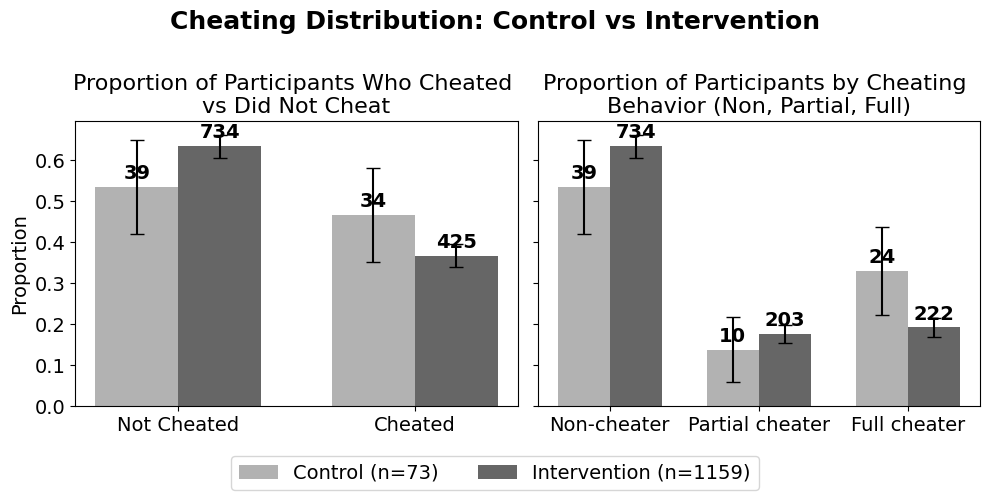


===== PROPORTION OF CHEATERS =====
Control group:
- Total N = 73
- Cheated: 34 participants (46.6%, 95% CI [35.1%, 58.0%])

Intervention group:
- Total N = 1159
- Cheated: 425 participants (36.7%, 95% CI [33.9%, 39.4%])

===== CHEATING BEHAVIOR BREAKDOWN =====

Control group:
Non-cheater: 39 participants (53.4%, 95% CI [42.0%, 64.9%])
Partial cheater: 10 participants (13.7%, 95% CI [5.8%, 21.6%])
Full cheater: 24 participants (32.9%, 95% CI [22.1%, 43.7%])

Intervention group:
Non-cheater: 734 participants (63.3%, 95% CI [60.6%, 66.1%])
Partial cheater: 203 participants (17.5%, 95% CI [15.3%, 19.7%])
Full cheater: 222 participants (19.2%, 95% CI [16.9%, 21.4%])


In [ ]:
# ============================================================================
# 5.6.1. EFFECT OF CONCEPT-BASED INTERVENTIONS ON CHEATING BEHAVIOR
# ============================================================================

print("\n" + "="*80)
print("5.6.1. EFFECT OF CONCEPT-BASED INTERVENTIONS ON CHEATING BEHAVIOR")
print("="*80)

# ============================================================================
# 5.6.1.1. Descriptive Statistics of Cheating Behavior
# ============================================================================

print("\n5.6.1.1. Descriptive Statistics of Cheating Behavior")
print("-" * 60)

# Calculate descriptive statistics
cheating_labels = {0: 'Non-cheater', 1: 'Partial cheater', 2: 'Full cheater'}
control_rates = control_data['cheating_behavior'].value_counts(normalize=True).sort_index() * 100
intervention_rates = df[df['concept'] != 'control']['cheating_behavior'].value_counts(normalize=True).sort_index() * 100

df['cheated_binary'] = (df['cheating_behavior'] > 0).astype(int)

# Helper function
def prop_ci(data, col, categories):
    n = len(data)
    props, ci_l, ci_u, counts = [], [], [], []
    for cat in categories:
        count = (data[col] == cat).sum()
        prop = count / n
        se = np.sqrt(prop * (1 - prop) / n)
        ci_low = max(0, prop - 1.96 * se)
        ci_high = min(1, prop + 1.96 * se)
        props.append(prop)
        ci_l.append(ci_low)
        ci_u.append(ci_high)
        counts.append(count)
    return props, ci_l, ci_u, counts

# Data subsets
control = df[df['concept'] == 'control']
intervention = df[df['concept'] != 'control']

# Figure setup
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Common settings
bar_width = 0.35
font_large = 14

# -------------------------
# PLOT 1: Cheated or Not
# -------------------------
cats1 = [0, 1]
control_p1, ci_l1, ci_u1, counts1 = prop_ci(control, 'cheated_binary', cats1)
interv_p1, ci_l2, ci_u2, counts2 = prop_ci(intervention, 'cheated_binary', cats1)

x = np.arange(len(cats1))
ax = axes[0]

bars1 = ax.bar(x - bar_width/2, control_p1, bar_width, 
               yerr=[np.array(control_p1)-np.array(ci_l1), np.array(ci_u1)-np.array(control_p1)],
               capsize=5, label=f'Control (n={len(control)})', color='gray', alpha=0.6)

bars2 = ax.bar(x + bar_width/2, interv_p1, bar_width,
               yerr=[np.array(interv_p1)-np.array(ci_l2), np.array(ci_u2)-np.array(interv_p1)],
               capsize=5, label=f'Intervention (n={len(intervention)})', color='black', alpha=0.6)

# Annotate counts
for bars, counts in zip([bars1, bars2], [counts1, counts2]):
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                count, ha='center', va='bottom', fontweight='bold', fontsize=font_large)

ax.set_xticks(x)
ax.set_xticklabels(['Not Cheated', 'Cheated'], fontsize=font_large)
ax.set_title('Proportion of Participants Who Cheated \nvs Did Not Cheat', fontsize=font_large + 2)
ax.set_ylabel('Proportion', fontsize=font_large)
ax.tick_params(axis='y', labelsize=font_large)

# -------------------------
# PLOT 2: Cheating Groups
# -------------------------
cats2 = [0, 1, 2]
control_p2, ci_l3, ci_u3, counts3 = prop_ci(control, 'cheating_behavior', cats2)
interv_p2, ci_l4, ci_u4, counts4 = prop_ci(intervention, 'cheating_behavior', cats2)

x2 = np.arange(len(cats2))
ax = axes[1]

bars3 = ax.bar(x2 - bar_width/2, control_p2, bar_width, 
               yerr=[np.array(control_p2)-np.array(ci_l3), np.array(ci_u3)-np.array(control_p2)],
               capsize=5, label=f'Control (n={len(control)})', color='gray', alpha=0.6)

bars4 = ax.bar(x2 + bar_width/2, interv_p2, bar_width,
               yerr=[np.array(interv_p2)-np.array(ci_l4), np.array(ci_u4)-np.array(interv_p2)],
               capsize=5, label=f'Intervention (n={len(intervention)})', color='black', alpha=0.6)

# Annotate counts
for bars, counts in zip([bars3, bars4], [counts3, counts4]):
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                count, ha='center', va='bottom', fontweight='bold', fontsize=font_large)

ax.set_xticks(x2)
ax.set_xticklabels(['Non-cheater', 'Partial cheater', 'Full cheater'], fontsize=font_large)
ax.set_title('Proportion of Participants by Cheating \nBehavior (Non, Partial, Full)', fontsize=font_large + 2)
ax.tick_params(axis='y', labelsize=font_large)


# Get handles and labels from the last axis
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=font_large)

plt.suptitle('Cheating Distribution: Control vs Intervention', fontsize=font_large + 4, fontweight='bold')
plt.tight_layout(rect=[0, 0.1, 1, 0.96])
plt.show()

print("\n===== PROPORTION OF CHEATERS =====")

print(f"Control group:")
print(f"- Total N = {len(control)}")
print(f"- Cheated: {counts1[1]} participants ({control_p1[1]*100:.1f}%, 95% CI [{ci_l1[1]*100:.1f}%, {ci_u1[1]*100:.1f}%])")

print(f"\nIntervention group:")
print(f"- Total N = {len(intervention)}")
print(f"- Cheated: {counts2[1]} participants ({interv_p1[1]*100:.1f}%, 95% CI [{ci_l2[1]*100:.1f}%, {ci_u2[1]*100:.1f}%])")

print("\n===== CHEATING BEHAVIOR BREAKDOWN =====")

print("\nControl group:")
for i, cat in enumerate(['Non-cheater', 'Partial cheater', 'Full cheater']):
    print(f"{cat}: {counts3[i]} participants ({control_p2[i]*100:.1f}%, 95% CI [{ci_l3[i]*100:.1f}%, {ci_u3[i]*100:.1f}%])")

print("\nIntervention group:")
for i, cat in enumerate(['Non-cheater', 'Partial cheater', 'Full cheater']):
    print(f"{cat}: {counts4[i]} participants ({interv_p2[i]*100:.1f}%, 95% CI [{ci_l4[i]*100:.1f}%, {ci_u4[i]*100:.1f}%])")



In [4]:
# ============================================================================
# 5.6.1.2. Statistical Analyses of Effect of Interventions on Cheating Behavior
# ============================================================================

print("\n5.6.1.2. Statistical Analyses of Effect of Interventions on Cheating Behavior")
print("-" * 70)

# Bayesian Multinomial Logistic Regression
with pm.Model() as cheating_model:
    # Control group baseline (empirical priors)
    n_total = control_cheating_counts.sum()
    n_non, n_partial, n_full = control_cheating_counts[0], control_cheating_counts[1], control_cheating_counts[2]
    
    control_partial_logit = np.log(n_partial / n_non) if n_non > 0 else -2
    control_full_logit = np.log(n_full / n_non) if n_non > 0 else -1
    se_partial = np.sqrt(1/n_partial + 1/n_non) if n_partial > 0 and n_non > 0 else 1.0
    se_full = np.sqrt(1/n_full + 1/n_non) if n_full > 0 and n_non > 0 else 1.0
    
    beta_partial_intercept = pm.Normal('beta_partial_intercept', mu=control_partial_logit, sigma=se_partial)
    beta_full_intercept = pm.Normal('beta_full_intercept', mu=control_full_logit, sigma=se_full)
    
    # Concept effects
    concept_effects_partial = pm.Normal('concept_effects_partial', mu=-0.5, sigma=1.0, shape=len(concepts))
    concept_effects_full = pm.Normal('concept_effects_full', mu=-0.5, sigma=1.0, shape=len(concepts))
    
    # Message random effects
    message_effects_partial = pm.Normal('message_effects_partial', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    message_effects_full = pm.Normal('message_effects_full', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    
    # Linear predictors
    eta_partial = (beta_partial_intercept + message_effects_partial[message_codes] + 
                   pm.math.switch(concept_codes > 0, concept_effects_partial[concept_codes - 1], 0))
    eta_full = (beta_full_intercept + message_effects_full[message_codes] + 
                pm.math.switch(concept_codes > 0, concept_effects_full[concept_codes - 1], 0))
    
    # Multinomial logistic probabilities
    logits = pm.math.stack([pm.math.zeros(eta_partial.shape), eta_partial, eta_full], axis=1)
    probs = pm.math.softmax(logits, axis=1)
    
    pm.Categorical('cheating_obs', p=probs, observed=y_cheating)

# Fit model
with cheating_model:
    trace_cheating = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9, random_seed=42)



5.6.1.2. Statistical Analyses of Effect of Interventions on Cheating Behavior
----------------------------------------------------------------------


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, concept_effects_partial, concept_effects_full, message_effects_partial, message_effects_full]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.


In [10]:
# =============================
# SUMMARY OF RESULTS (Posteriors)
# =============================

# Calculate predicted probabilities with HDI
beta_partial_samples = trace_cheating.posterior['beta_partial_intercept'].values.flatten()
beta_full_samples = trace_cheating.posterior['beta_full_intercept'].values.flatten()
partial_effects = trace_cheating.posterior['concept_effects_partial'].values.reshape(-1, len(concepts))
full_effects = trace_cheating.posterior['concept_effects_full'].values.reshape(-1, len(concepts))

# Control group probabilities
control_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples,
    beta_full_samples
])
control_probs = np.exp(control_logits) / np.exp(control_logits).sum(axis=1, keepdims=True)

# Order concepts by theory
theory_order = [
    'autonomy', 'competence', 'relatedness',  # Self-Determination
    'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',  # Cognitive Dissonance
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',  # Self-Efficacy
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification'  # Social Norms
]
theory_map = {
    'autonomy': 'Self-Determination Theory', 'competence': 'Self-Determination Theory', 'relatedness': 'Self-Determination Theory',
    'self_concept': 'Cognitive Dissonance Theory', 'cognitive_inconsistency': 'Cognitive Dissonance Theory', 
    'dissonance_arousal': 'Cognitive Dissonance Theory', 'dissonance_reduction': 'Cognitive Dissonance Theory',
    'performance_accomplishments': 'Self-Efficacy Theory', 'vicarious_experience': 'Self-Efficacy Theory', 
    'verbal_persuasion': 'Self-Efficacy Theory', 'emotional_arousal': 'Self-Efficacy Theory',
    'descriptive_norms': 'Social Norms Theory', 'injunctive_norms': 'Social Norms Theory', 
    'social_sanctions': 'Social Norms Theory', 'reference_group_identification': 'Social Norms Theory'
}

# Calculate differences for each concept with HDI
results_cheating = []
concept_differences = {}  # Store for reuse in forest plots

for concept in theory_order:
    if concept in concepts:
        i = concepts.index(concept)
        concept_logits = np.column_stack([
            np.zeros(len(beta_partial_samples)),
            beta_partial_samples + partial_effects[:, i],
            beta_full_samples + full_effects[:, i]
        ])
        concept_probs = np.exp(concept_logits) / np.exp(concept_logits).sum(axis=1, keepdims=True)
        
        # Differences with HDI
        non_diff = (concept_probs[:, 0] - control_probs[:, 0]) * 100
        partial_diff = (concept_probs[:, 1] - control_probs[:, 1]) * 100
        full_diff = (concept_probs[:, 2] - control_probs[:, 2]) * 100
        
        # Store for reuse
        concept_differences[concept] = {
            'non_diff': non_diff,
            'partial_diff': partial_diff,
            'full_diff': full_diff
        }
        
        results_cheating.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': non_diff.mean(),
            'Non_hdi': az.hdi(non_diff, hdi_prob=0.95),
            'Partial_mean': partial_diff.mean(),
            'Partial_hdi': az.hdi(partial_diff, hdi_prob=0.95),
            'Full_mean': full_diff.mean(),
            'Full_hdi': az.hdi(full_diff, hdi_prob=0.95)
        })

df_results = pd.DataFrame(results_cheating)

# Control baseline for labels
control_rates = {
    'Non': control_probs[:, 0].mean() * 100,
    'Partial': control_probs[:, 1].mean() * 100,
    'Full': control_probs[:, 2].mean() * 100
}

# Calculate overall intervention effects for reuse
overall_partial_effects = partial_effects.mean(axis=1)  
overall_full_effects = full_effects.mean(axis=1)

overall_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples + overall_partial_effects,
    beta_full_samples + overall_full_effects
])
overall_probs = np.exp(overall_logits) / np.exp(overall_logits).sum(axis=1, keepdims=True)

overall_results = {}
for i, category in enumerate(['Non', 'Partial', 'Full']):
    diff = (overall_probs[:, i] - control_probs[:, i]) * 100
    overall_results[category] = {
        'mean': diff.mean(),
        'hdi': az.hdi(diff, hdi_prob=0.95)
    }

# Print with HDI
print("Cheating Behavior Changes (percentage points) with 95% HDI:")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
print("-" * 130)
for _, row in df_results.iterrows():
    non_str = f"{row['Non_mean']:+.1f} [{row['Non_hdi'][0]:+.1f}, {row['Non_hdi'][1]:+.1f}]"
    partial_str = f"{row['Partial_mean']:+.1f} [{row['Partial_hdi'][0]:+.1f}, {row['Partial_hdi'][1]:+.1f}]"
    full_str = f"{row['Full_mean']:+.1f} [{row['Full_hdi'][0]:+.1f}, {row['Full_hdi'][1]:+.1f}]"
    print(f"{row['Concept']:<35} {row['Theory']:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")


Cheating Behavior Changes (percentage points) with 95% HDI:
Concept                             Theory                         Non-cheater               Partial                   Full                     
----------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +13.5 [-1.2, +27.2]       +0.4 [-12.1, +13.1]       -13.9 [-26.6, -1.5]      
Competence                          Self-Determination Theory      +13.3 [-0.9, +26.7]       -4.9 [-14.7, +5.6]        -8.4 [-20.6, +6.3]       
Relatedness                         Self-Determination Theory      +11.7 [-2.6, +25.3]       -5.3 [-14.9, +5.8]        -6.3 [-19.9, +8.3]       
Self Concept                        Cognitive Dissonance Theory    +11.5 [-2.0, +25.9]       -1.2 [-12.4, +10.5]       -10.3 [-22.9, +3.6]      
Cognitive Inconsistency             Cognitive Dissonance Theory    +14.3 [+0.3, +27.

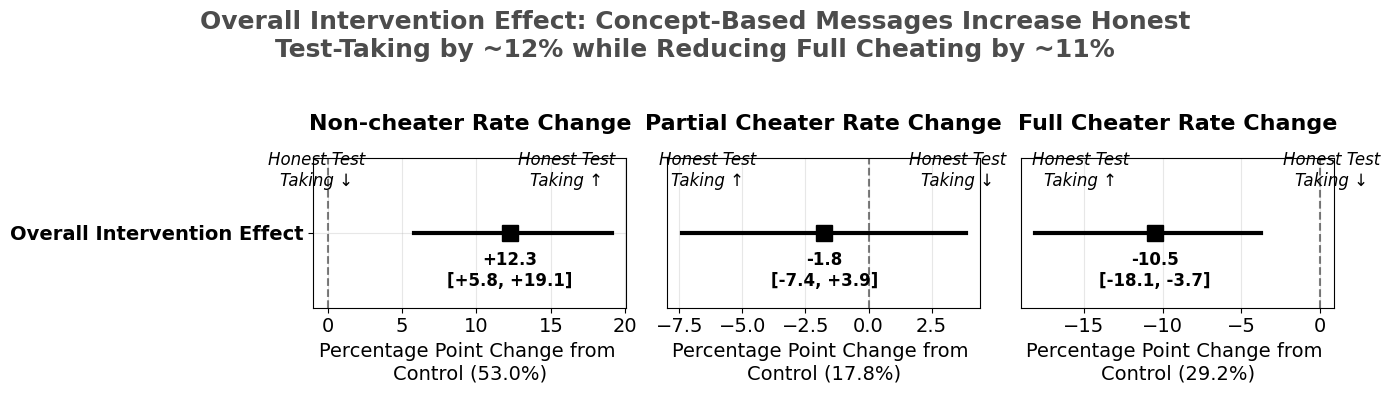

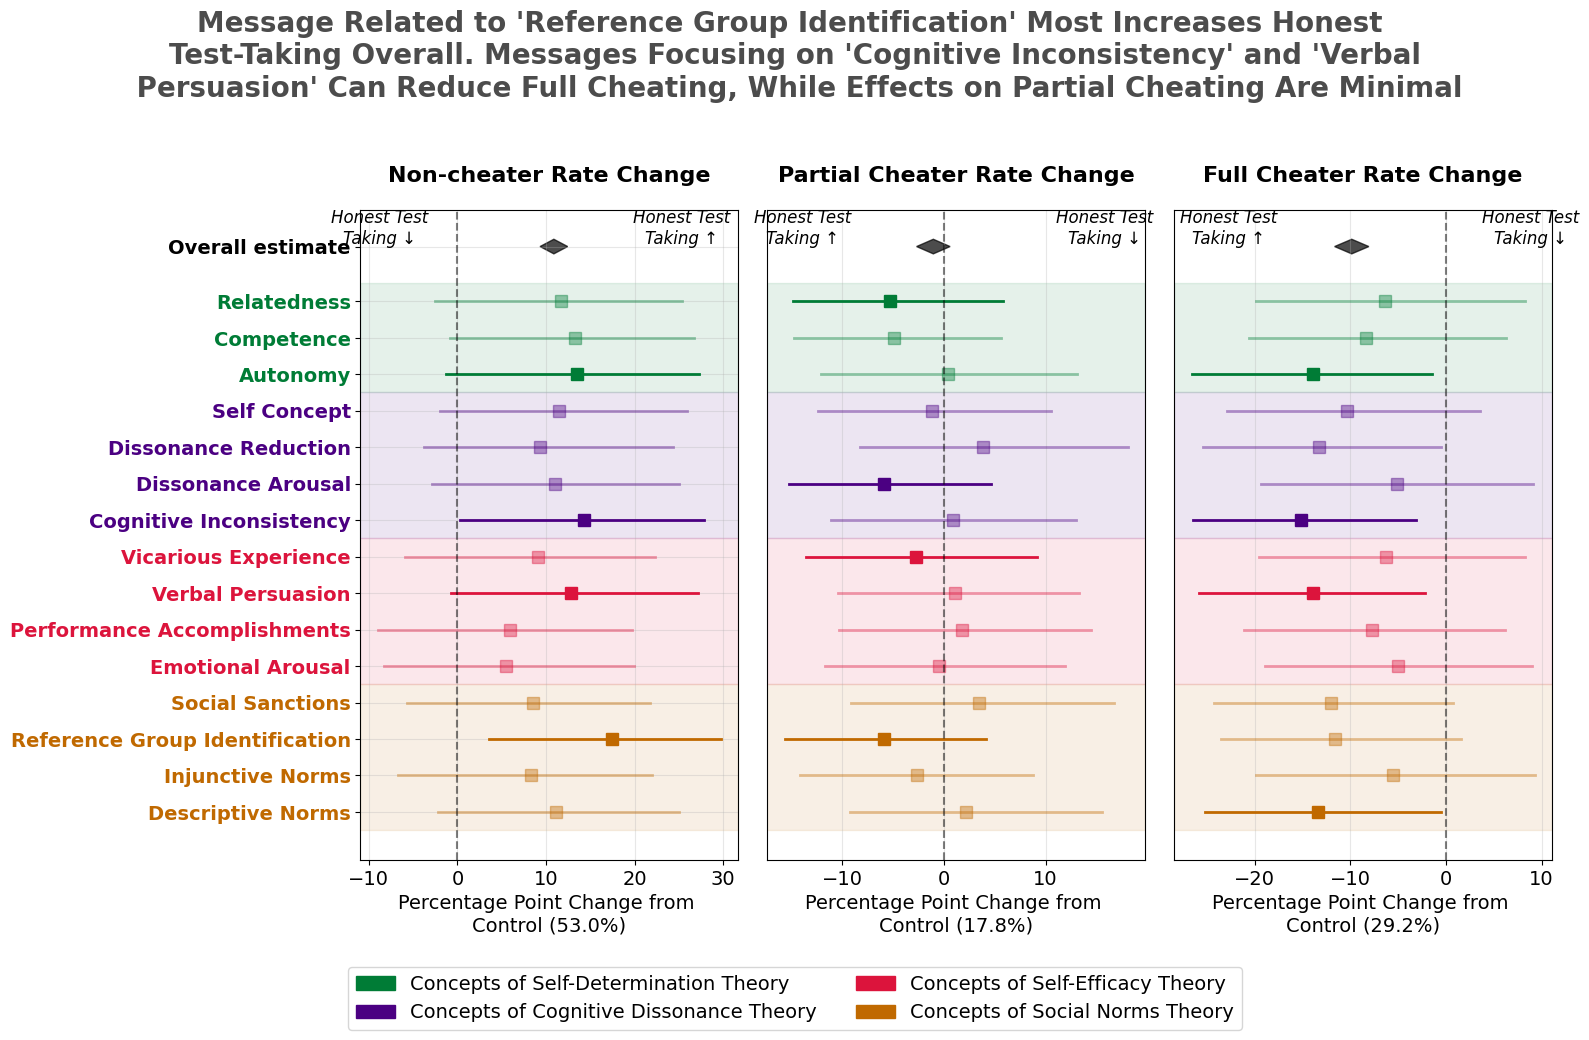

In [ ]:
# ===============================================================
# FOREST PLOTS FOR CHEATING BEHAVIOR (posterior with 95% HDI)

# RQ1a.  Do concept-based interventions reduce cheating behavior?
# RQ1b.  Do the effects on cheating vary by concepts?
# ================================================================

def create_forest_plots():
    """Create forest plots reusing calculated values from summary"""
    
    categories = ['Non', 'Partial', 'Full']
    titles = ['Non-cheater Rate Change', 'Partial Cheater Rate Change', 'Full Cheater Rate Change']
    
    # PLOT 1: Overall intervention effect (reuse overall_results)
    fig1, axes1 = plt.subplots(1, 3, figsize=(14, 4))
    
    for idx, (cat, title) in enumerate(zip(categories, titles)):
        ax = axes1[idx]
        
        mean = overall_results[cat]['mean']
        hdi = overall_results[cat]['hdi']
        
        ax.plot([hdi[0], hdi[1]], [0, 0], color='black', linewidth=3)
        ax.plot(mean, 0, 's', color='black', markersize=12)
        
        ax.text(mean, -0.15, f'{mean:+.1f}\n[{hdi[0]:+.1f}, {hdi[1]:+.1f}]', 
                ha='center', va='center', fontweight='bold', fontsize=12)
        
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)
        
        if idx == 0:
            ax.set_yticks([0])
            ax.set_yticklabels(['Overall Intervention Effect'], fontsize=14, fontweight='bold')
        else:
            ax.set_yticks([])
        
        ax.tick_params(axis='x', labelsize=14)
        ax.set_xlabel(f'Percentage Point Change from \nControl ({control_rates[cat]:.1f}%)', fontsize=14)
        ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.3, 0.3)
        
        xlim = ax.get_xlim()
        if cat == 'Non':
            ax.text(xlim[0] * 0.8, 0.25, 'Honest Test\nTaking ↓', ha='center', va='center', fontsize=12, style='italic')
            ax.text(xlim[1] * 0.8, 0.25, 'Honest Test\nTaking ↑', ha='center', va='center', fontsize=12, style='italic')
        else:
            ax.text(xlim[0] * 0.8, 0.25, 'Honest Test\nTaking ↑', ha='center', va='center', fontsize=12, style='italic')
            ax.text(xlim[1] * 0.8, 0.25, 'Honest Test\nTaking ↓', ha='center', va='center', fontsize=12, style='italic')

    plt.suptitle('Overall Intervention Effect: Concept-Based Messages Increase Honest\nTest-Taking by ~12% while Reducing Full Cheating by ~11%', 
                 fontsize=18, fontweight='bold', color="black", alpha=0.7, y=0.97)
    plt.tight_layout()
    plt.subplots_adjust(top=0.6)
    plt.show()
    
    # PLOT 2: By-concept effects (reuse df_results)
    import matplotlib.patches as patches
    
    fig2, axes2 = plt.subplots(1, 3, figsize=(16, 10))
    
    theory_order_viz = ['Self-Determination Theory', 'Cognitive Dissonance Theory', 'Self-Efficacy Theory', 'Social Norms Theory'][::-1]
    theory_colors = {'Self-Determination Theory': "#007C36", 'Cognitive Dissonance Theory': '#4B0082',
                     'Self-Efficacy Theory': '#DC143C', 'Social Norms Theory': "#C06900"}
    
    df_results['Theory'] = pd.Categorical(df_results['Theory'], categories=theory_order_viz, ordered=True)
    df_results_sorted = df_results.sort_values(['Theory', 'Concept']).reset_index(drop=True)
    
    for idx, (cat, title) in enumerate(zip(categories, titles)):
        ax = axes2[idx]
        means = df_results_sorted[f'{cat}_mean'].values
        hdis = np.array([row[f'{cat}_hdi'] for _, row in df_results_sorted.iterrows()])
        
        y_positions = np.arange(len(df_results_sorted))
        
        # Highlight best concept per theory
        highlight_indices = []
        for theory in theory_order_viz:
            indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
            if indices:
                theory_means = means[indices]
                target_idx = indices[np.argmax(theory_means)] if cat == 'Non' else indices[np.argmin(theory_means)]
                highlight_indices.append(target_idx)
        
        # Background shading and forest plot
        for theory in theory_order_viz:
            indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
            if indices:
                ax.axhspan(indices[0]-0.5, indices[-1]+0.5, alpha=0.1, color=theory_colors[theory])
        
        for i in range(len(df_results_sorted)):
            color = theory_colors[df_results_sorted.iloc[i]['Theory']]
            alpha = 1.0 if i in highlight_indices else 0.4
            ax.plot([hdis[i][0], hdis[i][1]], [i, i], color=color, alpha=alpha, linewidth=2)
            ax.plot(means[i], i, 's', color=color, alpha=alpha, markersize=8)
        
        # Overall estimate diamond
        overall_mean = means.mean()
        overall_se = np.std(means) / np.sqrt(len(means))
        diamond_y = len(df_results_sorted) + 0.5
        diamond_x = [overall_mean - 1.96*overall_se, overall_mean, overall_mean + 1.96*overall_se, overall_mean, overall_mean - 1.96*overall_se]
        diamond_y_coords = [diamond_y, diamond_y + 0.2, diamond_y, diamond_y - 0.2, diamond_y]
        ax.fill(diamond_x, diamond_y_coords, color='black', alpha=0.7)
        
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)

        if idx == 0:
            ax.set_yticks(list(y_positions) + [diamond_y])
            y_labels = df_results_sorted['Concept'].tolist() + ['Overall estimate']
            ax.set_yticklabels(y_labels, fontsize=14, fontweight='bold')

            for tick_label, concept in zip(ax.get_yticklabels()[:-1], df_results_sorted['Concept']):
                theory = df_results_sorted.loc[df_results_sorted['Concept'] == concept, 'Theory'].values[0]
                tick_label.set_color(theory_colors[theory])
            ax.get_yticklabels()[-1].set_color('black')
        else:
            ax.set_yticks([])

        ax.tick_params(axis='x', labelsize=14)
        ax.set_xlabel(f'Percentage Point Change from \nControl ({control_rates[cat]:.1f}%)', fontsize=14)
        ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
        ax.grid(True, alpha=0.3)
        
        xlim = ax.get_xlim()
        if cat == 'Non':
            ax.text(xlim[0] * 0.8, len(df_results_sorted) + 1, 'Honest Test\nTaking ↓', ha='center', va='center', fontsize=12, style='italic')
            ax.text(xlim[1] * 0.8, len(df_results_sorted) + 1, 'Honest Test\nTaking ↑', ha='center', va='center', fontsize=12, style='italic')
        else:
            ax.text(xlim[0] * 0.8, len(df_results_sorted) + 1, 'Honest Test\nTaking ↑', ha='center', va='center', fontsize=12, style='italic')
            ax.text(xlim[1] * 0.8, len(df_results_sorted) + 1, 'Honest Test\nTaking ↓', ha='center', va='center', fontsize=12, style='italic')

    legend_elements = [patches.Patch(color=color, label=f"Concepts of {theory}") for theory, color in theory_colors.items()]
    fig2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=14)

    plt.suptitle('Message Related to \'Reference Group Identification\' Most Increases Honest \nTest-Taking Overall. Messages Focusing on \'Cognitive Inconsistency\' and \'Verbal\n Persuasion\' Can Reduce Full Cheating, While Effects on Partial Cheating Are Minimal', 
             fontsize=20, fontweight='bold', color='black', alpha=0.7, y=0.95)

    plt.tight_layout()
    plt.subplots_adjust(top=0.75, bottom=0.1)
    plt.show()

# Execute the function
create_forest_plots()


5.6.2. EFFECT OF CONCEPT-BASED INTERVENTIONS ON PERFORMANCE AND USER EXPERIENCE

5.6.2.1. Descriptive Statistics of Performance
------------------------------------------------------------
Control group performance:
  N = 73
  Mean = 20.60 (SD = 12.73)
  95% CI = [17.68, 23.52]
Intervention group performance:
  N = 1159
  Mean = 19.34 (SD = 11.64)
  95% CI = [18.67, 20.01]

Performance by cheating behavior:

Control group:
  Non-cheater: 14.67 (SD=7.91, n=39)
  Partial cheater: 20.60 (SD=11.85, n=10)
  Full cheater: 30.25 (SD=13.85, n=24)

Intervention group:
  Non-cheater: 17.19 (SD=10.37, n=734)
  Partial cheater: 17.94 (SD=9.18, n=203)
  Full cheater: 27.73 (SD=13.73, n=222)

5.6.2.2. Descriptive Statistics of User Experience
------------------------------------------------------------
Control group experience:
  N = 73
  Mean = 5.55 (SD = 0.93)
  95% CI = [5.34, 5.76]
Intervention group experience:
  N = 1159
  Mean = 5.60 (SD = 0.80)
  95% CI = [5.56, 5.65]

Experience by cheatin

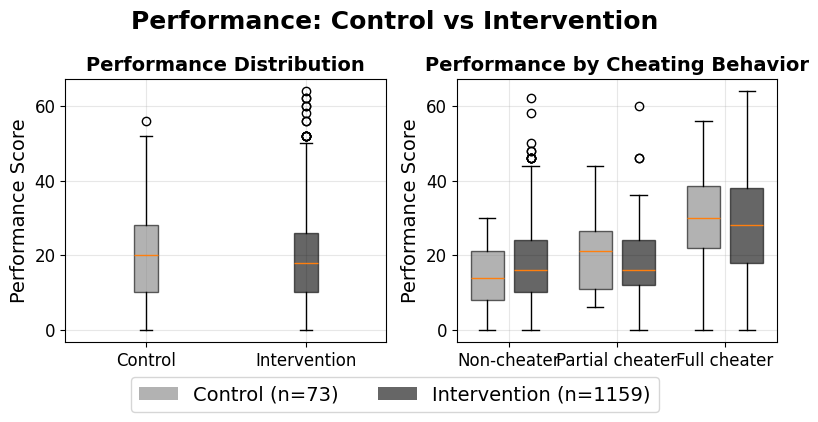

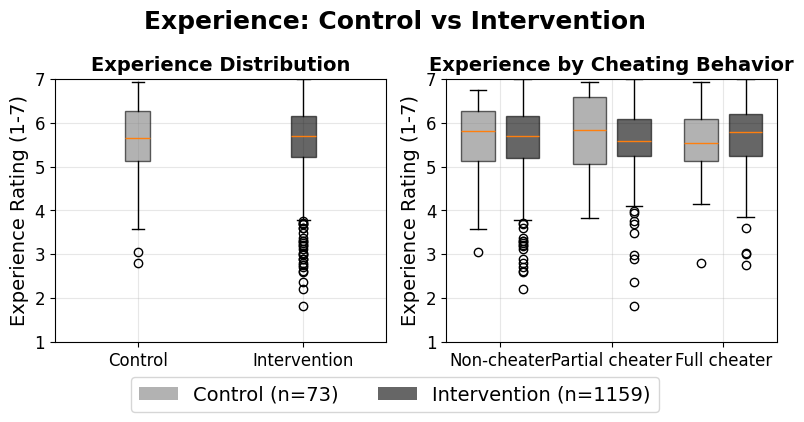

In [12]:
# ============================================================================
# 5.6.2. EFFECT OF CONCEPT-BASED INTERVENTIONS ON PERFORMANCE AND USER EXPERIENCE
# ============================================================================

print("\n" + "="*80)
print("5.6.2. EFFECT OF CONCEPT-BASED INTERVENTIONS ON PERFORMANCE AND USER EXPERIENCE")
print("="*80)

# ============================================================================
# 5.6.2.1. Descriptive Statistics of Performance
# ============================================================================

print("\n5.6.2.1. Descriptive Statistics of Performance")
print("-" * 60)

# Performance statistics by group
control_perf = control_data['performance']
intervention_perf = df[df['concept'] != 'control']['performance']

# Calculate means and CIs for performance
def calculate_stats(data, name):
    mean_val = data.mean()
    std_val = data.std()
    n = len(data)
    se = std_val / np.sqrt(n)
    ci_low = mean_val - 1.96 * se
    ci_high = mean_val + 1.96 * se
    
    print(f"{name}:")
    print(f"  N = {n}")
    print(f"  Mean = {mean_val:.2f} (SD = {std_val:.2f})")
    print(f"  95% CI = [{ci_low:.2f}, {ci_high:.2f}]")
    return mean_val, ci_low, ci_high, n

control_perf_stats = calculate_stats(control_perf, "Control group performance")
intervention_perf_stats = calculate_stats(intervention_perf, "Intervention group performance")

# Performance by cheating behavior
print("\nPerformance by cheating behavior:")
cheating_labels = {0: 'Non-cheater', 1: 'Partial cheater', 2: 'Full cheater'}

for group_name, group_data in [('Control', control_data), ('Intervention', df[df['concept'] != 'control'])]:
    print(f"\n{group_name} group:")
    for cheat_cat in [0, 1, 2]:
        subset = group_data[group_data['cheating_behavior'] == cheat_cat]['performance']
        if len(subset) > 0:
            print(f"  {cheating_labels[cheat_cat]}: {subset.mean():.2f} (SD={subset.std():.2f}, n={len(subset)})")

# ============================================================================
# 5.6.2.2. Descriptive Statistics of User Experience
# ============================================================================

print("\n5.6.2.2. Descriptive Statistics of User Experience")
print("-" * 60)

# Experience statistics by group
control_exp = control_data['experience']
intervention_exp = df[df['concept'] != 'control']['experience']

control_exp_stats = calculate_stats(control_exp, "Control group experience")
intervention_exp_stats = calculate_stats(intervention_exp, "Intervention group experience")

# Experience by cheating behavior
print("\nExperience by cheating behavior:")

for group_name, group_data in [('Control', control_data), ('Intervention', df[df['concept'] != 'control'])]:
    print(f"\n{group_name} group:")
    for cheat_cat in [0, 1, 2]:
        subset = group_data[group_data['cheating_behavior'] == cheat_cat]['experience']
        if len(subset) > 0:
            print(f"  {cheating_labels[cheat_cat]}: {subset.mean():.2f} (SD={subset.std():.2f}, n={len(subset)})")

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

positions = [0, 1, 2]

# ============================================================================
# VISUALIZATION: Performance Distributions
# ============================================================================

fig1, axes1 = plt.subplots(1, 2, figsize=(8, 4))

# Performance overall boxplot
axes1[0].boxplot([control_perf, intervention_perf], labels=['Control', 'Intervention'], patch_artist=True)
for i, patch in enumerate(axes1[0].patches):
    patch.set_facecolor(['gray', 'black'][i])
    patch.set_alpha(0.6)
axes1[0].set_title('Performance Distribution', fontweight='bold', fontsize=14)
axes1[0].set_ylabel('Performance Score', fontsize=14)
axes1[0].tick_params(axis='x', labelsize=12)
axes1[0].tick_params(axis='y', labelsize=12)
axes1[0].grid(True, alpha=0.3)

# Performance by cheating behavior
control_perf_by_cheat = [control_data[control_data['cheating_behavior'] == i]['performance'].values for i in range(3)]
intervention_perf_by_cheat = [df[(df['concept'] != 'control') & (df['cheating_behavior'] == i)]['performance'].values for i in range(3)]

bp1 = axes1[1].boxplot(control_perf_by_cheat, positions=[p - 0.2 for p in positions], widths=0.3, patch_artist=True, manage_ticks=False)
bp2 = axes1[1].boxplot(intervention_perf_by_cheat, positions=[p + 0.2 for p in positions], widths=0.3, patch_artist=True, manage_ticks=False)

for patch in bp1['boxes']:
    patch.set_facecolor('gray')
    patch.set_alpha(0.6)
for patch in bp2['boxes']:
    patch.set_facecolor('black')
    patch.set_alpha(0.6)

axes1[1].set_xticks(positions)
axes1[1].set_xticklabels(['Non-cheater', 'Partial cheater', 'Full cheater'], fontsize=12)
axes1[1].set_title('Performance by Cheating Behavior', fontweight='bold', fontsize=14)
axes1[1].set_ylabel('Performance Score', fontsize=14)
axes1[1].tick_params(axis='y', labelsize=12)
axes1[1].grid(True, alpha=0.3)

# Legend
legend_elements = [Patch(facecolor='gray', alpha=0.6, label=f'Control (n={len(control)})'),
                   Patch(facecolor='black', alpha=0.6, label=f'Intervention (n={len(intervention)})')]
fig1.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=14)

fig1.suptitle('Performance: Control vs Intervention', fontsize=18, fontweight='bold')
fig1.tight_layout()
fig1.subplots_adjust(bottom=0.15)
plt.show()


# ============================================================================
# VISUALIZATION: Experience Distributions
# ============================================================================

fig2, axes2 = plt.subplots(1, 2, figsize=(8, 4))

# Experience overall boxplot
axes2[0].boxplot([control_exp, intervention_exp], labels=['Control', 'Intervention'], patch_artist=True)
for i, patch in enumerate(axes2[0].patches):
    patch.set_facecolor(['gray', 'black'][i])
    patch.set_alpha(0.6)
axes2[0].set_title('Experience Distribution', fontweight='bold', fontsize=14)
axes2[0].set_ylabel('Experience Rating (1-7)', fontsize=14)
axes2[0].set_ylim(1, 7)
axes2[0].tick_params(axis='x', labelsize=12)
axes2[0].tick_params(axis='y', labelsize=12)
axes2[0].grid(True, alpha=0.3)

# Experience by cheating behavior
control_exp_by_cheat = [control_data[control_data['cheating_behavior'] == i]['experience'].values for i in range(3)]
intervention_exp_by_cheat = [df[(df['concept'] != 'control') & (df['cheating_behavior'] == i)]['experience'].values for i in range(3)]

bp1 = axes2[1].boxplot(control_exp_by_cheat, positions=[p - 0.2 for p in positions], widths=0.3, patch_artist=True, manage_ticks=False)
bp2 = axes2[1].boxplot(intervention_exp_by_cheat, positions=[p + 0.2 for p in positions], widths=0.3, patch_artist=True, manage_ticks=False)

for patch in bp1['boxes']:
    patch.set_facecolor('gray')
    patch.set_alpha(0.6)
for patch in bp2['boxes']:
    patch.set_facecolor('black')
    patch.set_alpha(0.6)

axes2[1].set_xticks(positions)
axes2[1].set_xticklabels(['Non-cheater', 'Partial cheater', 'Full cheater'], fontsize=12)
axes2[1].set_title('Experience by Cheating Behavior', fontweight='bold', fontsize=14)
axes2[1].set_ylabel('Experience Rating (1-7)', fontsize=14)
axes2[1].set_ylim(1, 7)
axes2[1].tick_params(axis='y', labelsize=12)
axes2[1].grid(True, alpha=0.3)

# Legend
fig2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=14)

fig2.suptitle('Experience: Control vs Intervention', fontsize=18, fontweight='bold')
fig2.tight_layout()
fig2.subplots_adjust(bottom=0.15)
plt.show()


In [13]:
# ============================================================================
# 5.6.2.3. Statistical Analyses of Effect on Performance and User Experience
# ============================================================================

print("\n5.6.2.3. Statistical Analyses of Effect on Performance and User Experience")
print("-" * 70)

# Control group baselines by cheating category
control_means_perf = []
control_means_exp = []

for cheat_cat in [0, 1, 2]:
    control_subset = control_data[control_data['cheating_behavior'] == cheat_cat]
    if len(control_subset) > 0:
        control_means_perf.append(control_subset['performance'].mean())
        control_means_exp.append(control_subset['experience'].mean())
    else:
        control_means_perf.append(control_performance_mean)
        control_means_exp.append(control_experience_mean)

print("Control group baselines by cheating category:")
print(f"Performance: {[f'{x:.2f}' for x in control_means_perf]}")
print(f"Experience: {[f'{x:.2f}' for x in control_means_exp]}")

# Multivariate Bayesian Model (since correlation > 0.1)
with pm.Model() as multivariate_model:
    # Control baselines by cheating category
    mu_exp_control = pm.Normal('mu_exp_control', mu=control_means_exp, sigma=0.3, shape=3)
    mu_perf_control = pm.Normal('mu_perf_control', mu=control_means_perf, sigma=3.0, shape=3)
    
    # Concept effects (main effects)
    concept_exp_main = pm.Normal('concept_exp_main', mu=0, sigma=0.2, shape=len(concepts))
    concept_perf_main = pm.Normal('concept_perf_main', mu=0, sigma=2.0, shape=len(concepts))
    
    # Concept × cheating category interactions
    concept_exp_interactions = pm.Normal('concept_exp_interactions', mu=0, sigma=0.15, shape=(len(concepts), 3))
    concept_perf_interactions = pm.Normal('concept_perf_interactions', mu=0, sigma=1.5, shape=(len(concepts), 3))
    
    # Message effects
    msg_exp = pm.Normal('msg_exp', mu=0, sigma=0.1, shape=len(message_ids.cat.categories))
    msg_perf = pm.Normal('msg_perf', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    
    # Linear predictors
    mu_exp = (mu_exp_control[y_cheating] + msg_exp[message_codes] + 
              pm.math.switch(concept_codes > 0,
                            concept_exp_main[concept_codes - 1] + concept_exp_interactions[concept_codes - 1, y_cheating], 0))

    mu_perf = (mu_perf_control[y_cheating] + msg_perf[message_codes] + 
               pm.math.switch(concept_codes > 0,
                             concept_perf_main[concept_codes - 1] + concept_perf_interactions[concept_codes - 1, y_cheating], 0))
    
    # Covariance structure
    sigma_exp = pm.HalfNormal('sigma_exp', sigma=0.4)
    sigma_perf = pm.HalfNormal('sigma_perf', sigma=5.0)
    rho = pm.Uniform('rho', lower=-0.5, upper=0.5)
    
    cov = pm.math.stack([[sigma_exp**2, rho*sigma_exp*sigma_perf],
                        [rho*sigma_exp*sigma_perf, sigma_perf**2]])
    
    # Multivariate likelihood
    outcomes = pm.math.stack([y_experience, y_performance], axis=1)
    means = pm.math.stack([mu_exp, mu_perf], axis=1)
    pm.MvNormal('outcomes', mu=means, cov=cov, observed=outcomes)

print("Fitting multivariate model...")
with multivariate_model:
    trace_multivariate = pm.sample(1000, tune=500, chains=4, cores=1, target_accept=0.9, random_seed=42)



5.6.2.3. Statistical Analyses of Effect on Performance and User Experience
----------------------------------------------------------------------
Control group baselines by cheating category:
Performance: ['14.67', '20.60', '30.25']
Experience: ['5.52', '5.69', '5.55']
Fitting multivariate model...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp_control, mu_perf_control, concept_exp_main, concept_perf_main, concept_exp_interactions, concept_perf_interactions, msg_exp, msg_perf, sigma_exp, sigma_perf, rho]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 168 seconds.


In [ ]:
# ============================================================================
# RESULTS ANALYSIS FOR PERFORMANCE AND EXPERIENCE
# ============================================================================

# Extract effect estimates (raw differences, not Cohen's d)
exp_main = trace_multivariate.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
exp_int = trace_multivariate.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)
perf_main = trace_multivariate.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
perf_int = trace_multivariate.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)

# Calculate overall effects (raw score differences from control)
overall_perf_non = np.mean([perf_main[:, i] + perf_int[:, i, 0] for i in range(len(concepts))], axis=0)
overall_perf_partial = np.mean([perf_main[:, i] + perf_int[:, i, 1] for i in range(len(concepts))], axis=0)
overall_perf_full = np.mean([perf_main[:, i] + perf_int[:, i, 2] for i in range(len(concepts))], axis=0)

overall_exp_non = np.mean([exp_main[:, i] + exp_int[:, i, 0] for i in range(len(concepts))], axis=0)
overall_exp_partial = np.mean([exp_main[:, i] + exp_int[:, i, 1] for i in range(len(concepts))], axis=0)
overall_exp_full = np.mean([exp_main[:, i] + exp_int[:, i, 2] for i in range(len(concepts))], axis=0)

# Store overall effects with HDI for reuse
overall_perf_exp_results = {
    'perf_non': {'mean': overall_perf_non.mean(), 'hdi': az.hdi(overall_perf_non, hdi_prob=0.95)},
    'perf_partial': {'mean': overall_perf_partial.mean(), 'hdi': az.hdi(overall_perf_partial, hdi_prob=0.95)},
    'perf_full': {'mean': overall_perf_full.mean(), 'hdi': az.hdi(overall_perf_full, hdi_prob=0.95)},
    'exp_non': {'mean': overall_exp_non.mean(), 'hdi': az.hdi(overall_exp_non, hdi_prob=0.95)},
    'exp_partial': {'mean': overall_exp_partial.mean(), 'hdi': az.hdi(overall_exp_partial, hdi_prob=0.95)},
    'exp_full': {'mean': overall_exp_full.mean(), 'hdi': az.hdi(overall_exp_full, hdi_prob=0.95)}
}

# Control baselines for display
control_perf_baselines = control_means_perf
control_exp_baselines = control_means_exp

print(f"\nOVERALL INTERVENTION EFFECTS (Raw Score Differences from Control):")
print(f"Performance differences:")
print(f"  Non-cheaters: {overall_perf_exp_results['perf_non']['mean']:+.2f} [{overall_perf_exp_results['perf_non']['hdi'][0]:+.2f}, {overall_perf_exp_results['perf_non']['hdi'][1]:+.2f}] (Control baseline: {control_perf_baselines[0]:.2f})")
print(f"  Partial cheaters: {overall_perf_exp_results['perf_partial']['mean']:+.2f} [{overall_perf_exp_results['perf_partial']['hdi'][0]:+.2f}, {overall_perf_exp_results['perf_partial']['hdi'][1]:+.2f}] (Control baseline: {control_perf_baselines[1]:.2f})")
print(f"  Full cheaters: {overall_perf_exp_results['perf_full']['mean']:+.2f} [{overall_perf_exp_results['perf_full']['hdi'][0]:+.2f}, {overall_perf_exp_results['perf_full']['hdi'][1]:+.2f}] (Control baseline: {control_perf_baselines[2]:.2f})")

print(f"\nExperience differences:")
print(f"  Non-cheaters: {overall_perf_exp_results['exp_non']['mean']:+.3f} [{overall_perf_exp_results['exp_non']['hdi'][0]:+.3f}, {overall_perf_exp_results['exp_non']['hdi'][1]:+.3f}] (Control baseline: {control_exp_baselines[0]:.2f})")
print(f"  Partial cheaters: {overall_perf_exp_results['exp_partial']['mean']:+.3f} [{overall_perf_exp_results['exp_partial']['hdi'][0]:+.3f}, {overall_perf_exp_results['exp_partial']['hdi'][1]:+.3f}] (Control baseline: {control_exp_baselines[1]:.2f})")
print(f"  Full cheaters: {overall_perf_exp_results['exp_full']['mean']:+.3f} [{overall_perf_exp_results['exp_full']['hdi'][0]:+.3f}, {overall_perf_exp_results['exp_full']['hdi'][1]:+.3f}] (Control baseline: {control_exp_baselines[2]:.2f})")

print(f"\nSUMMARY:")
print(f"All 95% credible intervals include zero, indicating no meaningful performance or experience costs from interventions.")




OVERALL INTERVENTION EFFECTS (Raw Score Differences from Control):
Performance differences:
  Non-cheaters: +0.10 [-0.94, +1.24] (Control baseline: 14.67)
  Partial cheaters: -0.10 [-1.22, +1.05] (Control baseline: 20.60)
  Full cheaters: -0.13 [-1.33, +0.90] (Control baseline: 30.25)

Experience differences:
  Non-cheaters: +0.010 [-0.105, +0.124] (Control baseline: 5.52)
  Partial cheaters: -0.001 [-0.112, +0.116] (Control baseline: 5.69)
  Full cheaters: +0.012 [-0.099, +0.124] (Control baseline: 5.55)

SUMMARY:
All 95% credible intervals include zero, indicating no meaningful performance or experience costs from interventions.


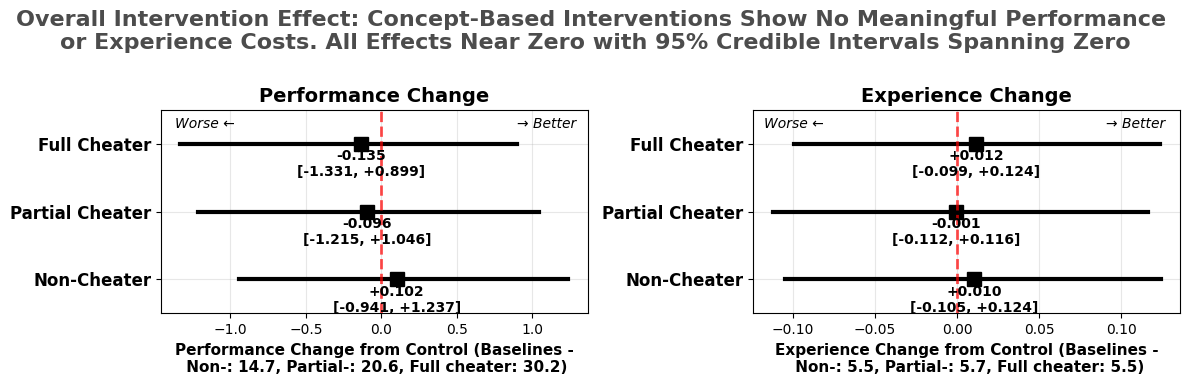

In [ ]:
# ============================================================================
# FOREST PLOTS FOR PERFORMANCE AND EXPERIENCE (posterior)
# RQ2a.  Do the interventions affect performance and user experience?
# RQ2b.  Do the effects on performance and experience vary by concepts?
# ============================================================================

def create_overall_effects_plot():
    """Create forest plot using pre-calculated overall effects"""
    
    # Control baselines
    control_baselines = {
        'Performance': control_means_perf,  # [14.67, 20.60, 30.25]
        'Experience': control_means_exp     # [5.52, 5.69, 5.55]
    }
    
    # Outcomes and labels (reuse calculated effects)
    outcomes = [
        ('Performance', [
            (overall_perf_exp_results['perf_non']['mean'], overall_perf_exp_results['perf_non']['hdi']),
            (overall_perf_exp_results['perf_partial']['mean'], overall_perf_exp_results['perf_partial']['hdi']),
            (overall_perf_exp_results['perf_full']['mean'], overall_perf_exp_results['perf_full']['hdi'])
        ]),
        ('Experience', [
            (overall_perf_exp_results['exp_non']['mean'], overall_perf_exp_results['exp_non']['hdi']),
            (overall_perf_exp_results['exp_partial']['mean'], overall_perf_exp_results['exp_partial']['hdi']),
            (overall_perf_exp_results['exp_full']['mean'], overall_perf_exp_results['exp_full']['hdi'])
        ])
    ]
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    for idx, (outcome_name, group_effects) in enumerate(outcomes):
        ax = axes[idx]
        
        for i, (group, (mean, hdi)) in enumerate(zip(groups, group_effects)):
            # Plot effect with HDI
            ax.plot([hdi[0], hdi[1]], [i, i], color='black', linewidth=3)
            ax.plot(mean, i, 's', color='black', markersize=10)
            
            # Add value label
            ax.text(mean, i - 0.3, f'{mean:+.3f}\n[{hdi[0]:+.3f}, {hdi[1]:+.3f}]', 
                    ha='center', va='center', fontweight='bold', fontsize=10)
        
        ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax.set_yticks(range(len(groups)))
        ax.set_yticklabels(groups, fontsize=12, fontweight='bold')
        
        baseline_text = f"Non-: {control_baselines[outcome_name][0]:.1f}, " + \
                       f"Partial-: {control_baselines[outcome_name][1]:.1f}, " + \
                       f"Full cheater: {control_baselines[outcome_name][2]:.1f}"
        
        ax.set_xlabel(f'{outcome_name} Change from Control (Baselines -\n {baseline_text})', 
                     fontsize=11, fontweight='bold')
        ax.set_title(f'{outcome_name} Change', fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, 2.5)
        
        # Add interpretation text
        xlim = ax.get_xlim()
        ax.text(xlim[0] * 0.8, 2.3, 'Worse ←', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
        ax.text(xlim[1] * 0.8, 2.3, '→ Better', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
    
    plt.suptitle('Overall Intervention Effect: Concept-Based Interventions Show No Meaningful Performance \nor Experience Costs. All Effects Near Zero with 95% Credible Intervals Spanning Zero', 
                 fontsize=16, fontweight='bold', color='black', alpha=0.7, y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.7)
    plt.show()

# Execute the plot
create_overall_effects_plot()

In [17]:
# ============================================================================
# 5.6.3.1. MEDIATOR AND MODERATOR VARIABLES (4 MEDIATORS + 2 MODERATORS)
# ============================================================================

print("5.6.3.1. Mediator and Moderator Variables")
print("-" * 45)

# 4 mediators (post-test, intervention-responsive)
mediator_vars = {
    'overall_need_fulfillment': 'Need Fulfillment',
    'task_specific_self_efficacy': 'Self Efficacy', 
    'norm_perception': 'Norm Perception',
    'cognitive_discomfort': 'Discomfort'
}

# 2 moderators (baseline traits)
moderator_vars = {
    'word_creation_skill_level': 'Ability',
    'moral_disengagement': 'Moral Disengagement'
}

print("MEDIATORS (post-test):")
available_mediators = {}
for var, label in mediator_vars.items():
    if var in df.columns:
        print(f"✓ {label}: {df[var].notna().sum()} values")
        available_mediators[label] = (df[var] - df[var].mean()) / df[var].std()
    else:
        print(f"✗ {label}: NOT FOUND")

print(f"\nMODERATORS (baseline traits):")
available_moderators = {}
for var, label in moderator_vars.items():
    if var in df.columns:
        print(f"✓ {label}: {df[var].notna().sum()} values")
        available_moderators[label] = (df[var] - df[var].mean()) / df[var].std()
    else:
        print(f"✗ {label}: NOT FOUND")

# Mediator correlations
if len(available_mediators) >= 2:
    med_values = list(available_mediators.values())
    med_names = list(available_mediators.keys())
    med_corr = np.corrcoef(med_values)
    
    print(f"\nMEDIATOR CORRELATIONS:")
    print("-" * 25)
    for i, name1 in enumerate(med_names):
        for j, name2 in enumerate(med_names):
            if i < j:
                print(f"{name1} - {name2}: {med_corr[i,j]:.3f}")

print(f"\nMODEL SPECIFICATION:")
print("Mediators: Concepts → Mediators → Outcomes")
print("Moderators: Moderators × Concepts → Outcomes")

5.6.3.1. Mediator and Moderator Variables
---------------------------------------------
MEDIATORS (post-test):
✓ Need Fulfillment: 1232 values
✓ Self Efficacy: 1232 values
✓ Norm Perception: 1232 values
✓ Discomfort: 1232 values

MODERATORS (baseline traits):
✓ Ability: 1232 values
✓ Moral Disengagement: 1232 values

MEDIATOR CORRELATIONS:
-------------------------
Need Fulfillment - Self Efficacy: 0.461
Need Fulfillment - Norm Perception: 0.249
Need Fulfillment - Discomfort: -0.554
Self Efficacy - Norm Perception: 0.689
Self Efficacy - Discomfort: -0.186
Norm Perception - Discomfort: -0.034

MODEL SPECIFICATION:
Mediators: Concepts → Mediators → Outcomes
Moderators: Moderators × Concepts → Outcomes


In [18]:
# ============================================================================
# 5.6.3.2. MEDIATION + MODERATION MODELS (4 MEDIATORS + 2 MODERATORS)
# ============================================================================

if len(available_mediators) >= 2 and len(available_moderators) >= 1:
    
    print("\n" + "="*80)
    print("5.6.3.2. Mediation Models: Concepts → Mediators → Outcomes + Moderation")
    print("="*80)
    
    # Prepare mediator and moderator data
    mediator_keys = list(available_mediators.keys())
    moderator_keys = list(available_moderators.keys())
    
    print(f"Mediators ({len(mediator_keys)}): {mediator_keys}")
    print(f"Moderators ({len(moderator_keys)}): {moderator_keys}")
    
    # MODEL 3A: Concepts → Mediators (PATH A)
    with pm.Model() as mediator_model:
        for med_name, med_values in available_mediators.items():
            key = med_name.lower().replace(' ', '_').replace('Disengagement', '')
            
            # Group-specific baselines
            baseline = pm.Normal(f'{key}_baseline', mu=0, sigma=0.5, shape=3)
            
            # Group-specific concept effects
            concept_effects = pm.Normal(f'{key}_concept_effects', mu=0, sigma=0.3, shape=(len(concepts), 3))
            
            # Message effects
            message_effects = pm.Normal(f'{key}_message_effects', mu=0, sigma=0.2, shape=len(message_ids.cat.categories))
            
            # Linear predictor
            mu = baseline[y_cheating] + message_effects[message_codes]
            mu += pm.math.switch(concept_codes > 0, 
                                concept_effects[concept_codes - 1, y_cheating], 0)
            
            pm.Normal(f'{key}_obs', mu=mu, sigma=pm.HalfNormal(f'{key}_sigma', sigma=0.5), 
                     observed=med_values)
    
    # MODEL 3B: Mediators + Concepts → Outcomes + Moderation (PATH B + C' + INTERACTIONS)
    with pm.Model() as outcome_model:
        # Stack mediators
        mediator_matrix = np.column_stack([available_mediators[key] for key in mediator_keys])
        n_mediators = len(mediator_keys)
        
        # Stack moderators
        moderator_matrix = np.column_stack([available_moderators[key] for key in moderator_keys])
        n_moderators = len(moderator_keys)
        
        # Performance model
        perf_baseline = pm.Normal('perf_baseline', mu=control_means_perf, sigma=2.0, shape=3)
        
        # PATH B: Mediator → Performance
        perf_mediator_effects = pm.Normal('perf_mediator_effects', mu=0, sigma=1.0, shape=(n_mediators, 3))
        
        # PATH C': Direct concept → Performance
        perf_concept_direct = pm.Normal('perf_concept_direct', mu=0, sigma=1.5, shape=(len(concepts), 3))
        
        # MODERATION: Moderator × Concept → Performance
        perf_moderation = pm.Normal('perf_moderation', mu=0, sigma=1.0, shape=(n_moderators, len(concepts), 3))
        
        # Linear predictor for performance
        mu_perf = perf_baseline[y_cheating]
        
        # Add mediator effects
        for med_idx in range(n_mediators):
            mu_perf += mediator_matrix[:, med_idx] * perf_mediator_effects[med_idx, y_cheating]
        
        # Add direct concept effects
        mu_perf += pm.math.switch(concept_codes > 0, perf_concept_direct[concept_codes - 1, y_cheating], 0)
        
        # Add moderation effects
        for mod_idx in range(n_moderators):
            mu_perf += pm.math.switch(concept_codes > 0, 
                                     moderator_matrix[:, mod_idx] * perf_moderation[mod_idx, concept_codes - 1, y_cheating], 0)
        
        # Experience model
        exp_baseline = pm.Normal('exp_baseline', mu=control_means_exp, sigma=0.3, shape=3)
        
        # PATH B: Mediator → Experience
        exp_mediator_effects = pm.Normal('exp_mediator_effects', mu=0, sigma=0.3, shape=(n_mediators, 3))
        
        # PATH C': Direct concept → Experience
        exp_concept_direct = pm.Normal('exp_concept_direct', mu=0, sigma=0.3, shape=(len(concepts), 3))
        
        # MODERATION: Moderator × Concept → Experience
        exp_moderation = pm.Normal('exp_moderation', mu=0, sigma=0.2, shape=(n_moderators, len(concepts), 3))
        
        # Linear predictor for experience
        mu_exp = exp_baseline[y_cheating]
        
        # Add mediator effects
        for med_idx in range(n_mediators):
            mu_exp += mediator_matrix[:, med_idx] * exp_mediator_effects[med_idx, y_cheating]
        
        # Add direct concept effects
        mu_exp += pm.math.switch(concept_codes > 0, exp_concept_direct[concept_codes - 1, y_cheating], 0)
        
        # Add moderation effects
        for mod_idx in range(n_moderators):
            mu_exp += pm.math.switch(concept_codes > 0,
                                    moderator_matrix[:, mod_idx] * exp_moderation[mod_idx, concept_codes - 1, y_cheating], 0)
        
        # Likelihoods
        pm.Normal('performance', mu=mu_perf, sigma=pm.HalfNormal('perf_sigma', sigma=5.0), observed=y_performance)
        pm.Normal('experience', mu=mu_exp, sigma=pm.HalfNormal('exp_sigma', sigma=0.5), observed=y_experience)
    
    # Fit models
    print("Fitting mediation + moderation models...")
    with mediator_model:
        trace_mediators = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)
    
    with outcome_model:
        trace_outcomes = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)
    
    print("Models fitted successfully!")


5.6.3.2. Mediation Models: Concepts → Mediators → Outcomes + Moderation
Mediators (4): ['Need Fulfillment', 'Self Efficacy', 'Norm Perception', 'Discomfort']
Moderators (2): ['Ability', 'Moral Disengagement']
Fitting mediation + moderation models...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [need_fulfillment_baseline, need_fulfillment_concept_effects, need_fulfillment_message_effects, need_fulfillment_sigma, self_efficacy_baseline, self_efficacy_concept_effects, self_efficacy_message_effects, self_efficacy_sigma, norm_perception_baseline, norm_perception_concept_effects, norm_perception_message_effects, norm_perception_sigma, discomfort_baseline, discomfort_concept_effects, discomfort_message_effects, discomfort_sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 37 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [perf_baseline, perf_mediator_effects, perf_concept_direct, perf_moderation, exp_baseline, exp_mediator_effects, exp_concept_direct, exp_moderation, perf_sigma, exp_sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 70 seconds.


Models fitted successfully!


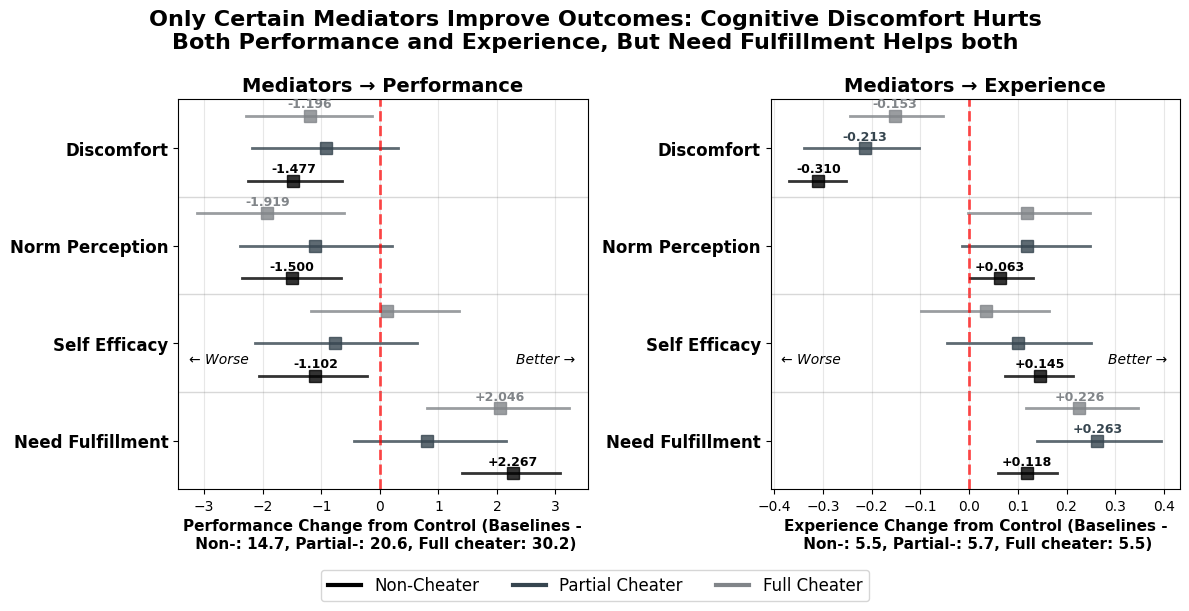


PATH B: MEDIATORS → OUTCOMES (Forest Plot Data)

Performance:
Mediator             Group           Mean     95% HDI             
------------------------------------------------------------
Need Fulfillment     Non             +2.267 [+1.395, +3.085]
Need Fulfillment     Partial         +0.813 [-0.444, +2.152]
Need Fulfillment     Full            +2.046 [+0.811, +3.229]
Self Efficacy        Non             -1.102 [-2.059, -0.224]
Self Efficacy        Partial         -0.762 [-2.124, +0.640]
Self Efficacy        Full            +0.114 [-1.173, +1.350]
Norm Perception      Non             -1.500 [-2.352, -0.665]
Norm Perception      Partial         -1.109 [-2.381, +0.212]
Norm Perception      Full            -1.919 [-3.126, -0.617]
Discomfort           Non             -1.477 [-2.249, -0.639]
Discomfort           Partial         -0.912 [-2.188, +0.318]
Discomfort           Full            -1.196 [-2.284, -0.128]

Experience:
Mediator             Group           Mean     95% HDI           

In [ ]:
# ============================================================================
# FOREST PLOT: MEDIATORS ((need fulfillment, self-efficacy, norm perception, 
# cognitive discomfort)) → OUTCOMES (performance, experience)

# RQ3: How do concept-based interventions influence cheating behavior, performance and user experience?
# ============================================================================

def create_path_b_forest_plot():
    
    # Extract PATH B effects
    perf_med_effects = trace_outcomes.posterior['perf_mediator_effects'].values.reshape(-1, len(mediator_keys), 3)
    exp_med_effects = trace_outcomes.posterior['exp_mediator_effects'].values.reshape(-1, len(mediator_keys), 3)
    
    control_baselines = {
        'Performance': control_means_perf,  # [14.67, 20.60, 30.25]
        'Experience': control_means_exp     # [5.52, 5.69, 5.55]
    }
    
    outcomes = [
        ('Performance', perf_med_effects),
        ('Experience', exp_med_effects)
    ]
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for idx, (outcome_name, med_effects) in enumerate(outcomes):
        ax = axes[idx]
        
        # Colors for each group
        colors = ['#000000', '#36454F', '#818589']
        
        for j, med_name in enumerate(mediator_keys):
            for i, (group, group_idx) in enumerate(zip(groups, [0, 1, 2])):
                # Proper y positioning: each mediator gets 3 positions (one per group)
                y_pos = j * 3 + i
                effects = med_effects[:, j, group_idx]
                
                mean = effects.mean()
                hdi = az.hdi(effects, hdi_prob=0.95)
                
                # Plot effect with CI
                ax.plot([hdi[0], hdi[1]], [y_pos, y_pos], color=colors[i], linewidth=2, alpha=0.8)
                ax.plot(mean, y_pos, 's', color=colors[i], markersize=8, alpha=0.8)
                
                # Add value label for significant effects (HDI doesn't cross 0)
                if hdi[0] > 0 or hdi[1] < 0:
                    ax.text(mean, y_pos + 0.15, f'{mean:+.3f}', ha='center', va='bottom', 
                           fontweight='bold', fontsize=9, color=colors[i])
        
        # Formatting
        ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add horizontal lines to separate mediators
        for j in range(1, len(mediator_keys)):
            ax.axhline(j * 3 - 0.5, color='gray', linestyle='-', alpha=0.3, linewidth=1)
        
        # Y-axis: mediator labels at center of each group
        y_ticks = [j * 3 + 1 for j in range(len(mediator_keys))]  # Center position for each mediator
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(mediator_keys, fontsize=12, fontweight='bold')
        ax.set_ylim(-0.5, len(mediator_keys) * 3 - 0.5)
        
        baseline_text = f"Non-: {control_baselines[outcome_name][0]:.1f}, " + \
                       f"Partial-: {control_baselines[outcome_name][1]:.1f}, " + \
                       f"Full cheater: {control_baselines[outcome_name][2]:.1f}"
        
        ax.set_xlabel(f'{outcome_name} Change from Control (Baselines -\n {baseline_text})', 
                     fontsize=11, fontweight='bold')
        ax.set_title(f'Mediators → {outcome_name}', fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add interpretation text
        xlim = ax.get_xlim()
        ax.text(xlim[0] * 0.8, len(mediator_keys) - 0.5, '← Worse', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
        ax.text(xlim[1] * 0.8, len(mediator_keys) - 0.5, 'Better →', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
    
    # Legend
    legend_elements = [plt.Line2D([0], [0], color=color, lw=3, label=group) 
                      for color, group in zip(['#000000', '#36454F', '#818589'], groups)]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
              ncol=3, fontsize=12)
    
    plt.suptitle('Only Certain Mediators Improve Outcomes: Cognitive Discomfort Hurts\nBoth Performance and Experience, But Need Fulfillment Helps both', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8, bottom=0.15)
    plt.show()

# Execute the plot
create_path_b_forest_plot()

# Print PATH B effects data used in forest plot
print("\n" + "="*80)
print("PATH B: MEDIATORS → OUTCOMES (Forest Plot Data)")
print("="*80)

# Extract the same data used in the plot
perf_med_effects = trace_outcomes.posterior['perf_mediator_effects'].values.reshape(-1, len(mediator_keys), 3)
exp_med_effects = trace_outcomes.posterior['exp_mediator_effects'].values.reshape(-1, len(mediator_keys), 3)

outcomes = [('Performance', perf_med_effects), ('Experience', exp_med_effects)]
groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']

for outcome_name, med_effects in [('Performance', perf_med_effects), ('Experience', exp_med_effects)]:
    print(f"\n{outcome_name}:")
    print(f"{'Mediator':<20} {'Group':<15} {'Mean':<8} {'95% HDI':<20}")
    print("-"*60)
    
    for j, med_name in enumerate(mediator_keys):
        for i, group in enumerate(['Non', 'Partial', 'Full']):
            effects = med_effects[:, j, i]
            mean = effects.mean()
            hdi = az.hdi(effects, hdi_prob=0.95)
            
            print(f"{med_name:<20} {group:<15} {mean:+.3f} [{hdi[0]:+.3f}, {hdi[1]:+.3f}]")
            
print(f"\nBaselines:\nPerformance: {control_means_perf},\nExperience: {control_means_exp}")

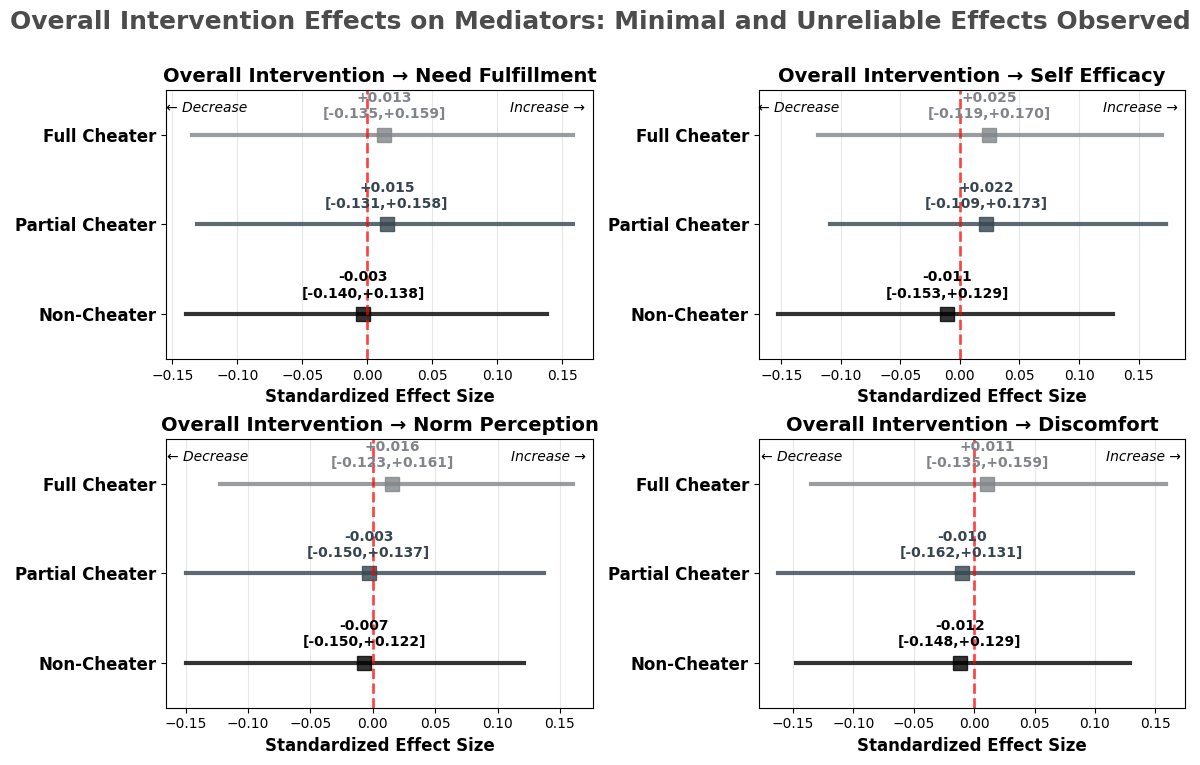


OVERALL INTERVENTION → MEDIATORS (Forest Plot Data)

NEED FULFILLMENT:
Group           Mean     95% HDI             
--------------------------------------------------
Non-Cheater     -0.003 [-0.140, +0.138]
Partial Cheater +0.015 [-0.131, +0.158]
Full Cheater    +0.013 [-0.135, +0.159]

SELF EFFICACY:
Group           Mean     95% HDI             
--------------------------------------------------
Non-Cheater     -0.011 [-0.153, +0.129]
Partial Cheater +0.022 [-0.109, +0.173]
Full Cheater    +0.025 [-0.119, +0.170]

NORM PERCEPTION:
Group           Mean     95% HDI             
--------------------------------------------------
Non-Cheater     -0.007 [-0.150, +0.122]
Partial Cheater -0.003 [-0.150, +0.137]
Full Cheater    +0.016 [-0.123, +0.161]

DISCOMFORT:
Group           Mean     95% HDI             
--------------------------------------------------
Non-Cheater     -0.012 [-0.148, +0.129]
Partial Cheater -0.010 [-0.162, +0.131]
Full Cheater    +0.011 [-0.135, +0.159]

Note: Effect

In [22]:
# ============================================================================
# FOREST PLOT: OVERALL INTERVENTION → MEDIATORS (need fulfillment, self-efficacy, 
# norm perception, cognitive discomfort)
# ============================================================================

def create_overall_intervention_mediators_plot():
    """Create forest plot for overall intervention effects on mediators by cheating group"""
    
    # Extract PATH A effects and calculate overall intervention effects
    mediator_effects = {}
    overall_effects = {}
    
    for i, med_name in enumerate(mediator_keys):
        key = med_name.lower().replace(' ', '_').replace('disengagement', '')
        concept_effects = trace_mediators.posterior[f'{key}_concept_effects'].values.reshape(-1, len(concepts), 3)
        
        # Calculate overall intervention effect (average across all concepts)
        overall_effects[med_name] = concept_effects.mean(axis=1)  # Shape: (samples, 3 groups)
        mediator_effects[med_name] = concept_effects
    
    # Create 2x2 subplot for 4 mediators
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    colors = ['#000000', '#36454F', '#818589']
    
    for med_idx, med_name in enumerate(mediator_keys):
        ax = axes[med_idx]
        overall_med_effects = overall_effects[med_name]
        
        for i, (group, color) in enumerate(zip(groups, colors)):
            effects = overall_med_effects[:, i]
            
            mean = effects.mean()
            hdi = az.hdi(effects, hdi_prob=0.95)
            
            # Plot effect with HDI
            ax.plot([hdi[0], hdi[1]], [i, i], color=color, linewidth=3, alpha=0.8)
            ax.plot(mean, i, 's', color=color, markersize=10, alpha=0.8)
            
            # Add value label
            ax.text(mean, i + 0.15, f'{mean:+.3f}\n[{hdi[0]:+.3f},{hdi[1]:+.3f}]', 
                   ha='center', va='bottom', fontweight='bold', fontsize=10, color=color)
        
        # Formatting
        ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax.set_yticks(range(len(groups)))
        ax.set_yticklabels(groups, fontsize=12, fontweight='bold')
        ax.set_ylim(-0.5, 2.5)
        ax.set_xlabel('Standardized Effect Size', fontsize=12, fontweight='bold')
        ax.set_title(f'Overall Intervention → {med_name}', fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add interpretation text
        xlim = ax.get_xlim()
        ax.text(xlim[0] * 0.8, 2.3, '← Decrease', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
        ax.text(xlim[1] * 0.8, 2.3, 'Increase →', ha='center', va='center', 
                fontsize=10, style='italic', color='black')
    
    plt.suptitle('Overall Intervention Effects on Mediators: Minimal and Unreliable Effects Observed', 
                 fontsize=18, fontweight='bold', color='black', alpha=0.7, y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    return overall_effects

# Execute the plot and capture data
overall_effects_data = create_overall_intervention_mediators_plot()

# Print data used in plot
print("\n" + "="*80)
print("OVERALL INTERVENTION → MEDIATORS (Forest Plot Data)")
print("="*80)

groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']

for med_name in mediator_keys:
    print(f"\n{med_name.upper()}:")
    print(f"{'Group':<15} {'Mean':<8} {'95% HDI':<20}")
    print("-"*50)
    
    med_effects = overall_effects_data[med_name]
    for i, group in enumerate(groups):
        effects = med_effects[:, i]
        mean = effects.mean()
        hdi = az.hdi(effects, hdi_prob=0.95)
        print(f"{group:<15} {mean:+.3f} [{hdi[0]:+.3f}, {hdi[1]:+.3f}]")

print(f"\nNote: Effects represent average across all {len(concepts)} concepts")
print(f"Mediators: {mediator_keys}")

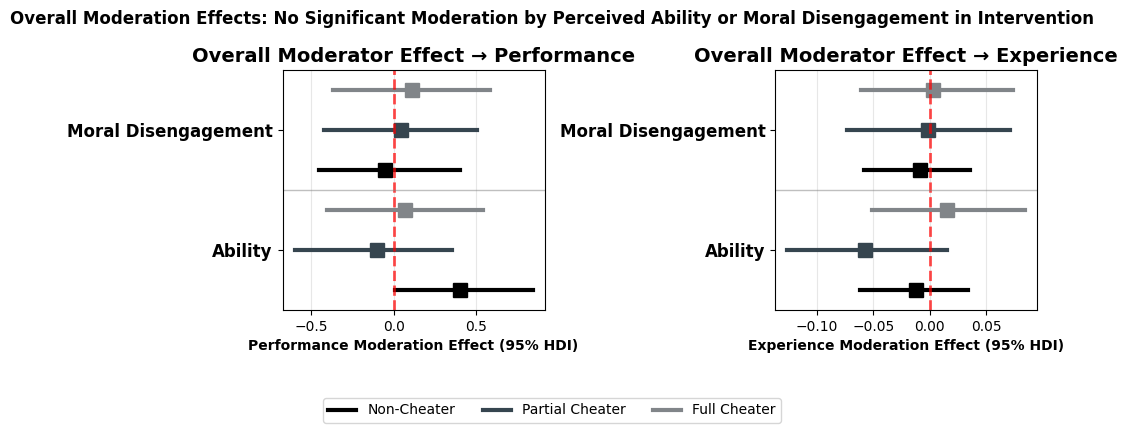

In [24]:
# ============================================================================
# FOREST PLOT: OVERALL MODERATION EFFECTS (Perceived ability and moral disengagement)
# ============================================================================

def create_overall_moderation_forest_plot():
    """Forest plot showing overall moderation effects (averaged across concepts)"""
    
    # Extract moderation effects and calculate overall effects
    perf_mod = trace_outcomes.posterior['perf_moderation'].values.reshape(-1, len(moderator_keys), len(concepts), 3)
    exp_mod = trace_outcomes.posterior['exp_moderation'].values.reshape(-1, len(moderator_keys), len(concepts), 3)
    
    # Average across all concepts for overall effect
    perf_overall = perf_mod.mean(axis=2)  # Shape: (samples, moderators, groups)
    exp_overall = exp_mod.mean(axis=2)
    
    groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
    colors = ['#000000', '#36454F', '#818589']
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    for idx, (outcome, effects) in enumerate([('Performance', perf_overall), ('Experience', exp_overall)]):
        ax = axes[idx]
        
        for j, mod_name in enumerate(moderator_keys):
            for i, group in enumerate(groups):
                y_pos = j * 3 + i
                samples = effects[:, j, i]
                
                mean = samples.mean()
                hdi = az.hdi(samples, hdi_prob=0.95)
                
                # Plot HDI and mean
                ax.plot([hdi[0], hdi[1]], [y_pos, y_pos], color=colors[i], linewidth=3)
                ax.plot(mean, y_pos, 's', color=colors[i], markersize=10)
                
                # Add value label
                # ax.text(mean, y_pos - 0.2, f'{mean:+.3f}\n[{hdi[0]:+.3f},{hdi[1]:+.3f}]', 
                        # ha='center', va='center', fontweight='bold', fontsize=10)
        
        # Formatting
        ax.axvline(0, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax.axhline(2.5, color='gray', alpha=0.5, linewidth=1)  # Separate moderators
        
        # Y-labels
        y_ticks = [1, 4]  # Center of each moderator group
        y_labels = moderator_keys
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_labels, fontsize=12, fontweight='bold')
        
        ax.set_xlabel(f'{outcome} Moderation Effect (95% HDI)', fontweight='bold')
        ax.set_title(f'Overall Moderator Effect → {outcome}', fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3, axis='x')
        ax.set_ylim(-0.5, 5.5)
    
    # Legend
    legend_elements = [plt.Line2D([0], [0], color=color, lw=3, label=group) 
                      for color, group in zip(colors, groups)]
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    plt.suptitle('Overall Moderation Effects: No Significant Moderation by Perceived Ability or Moral Disengagement in Intervention', 
                 fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8, bottom=0.2)
    plt.show()

create_overall_moderation_forest_plot()

In [25]:
# ============================================================================
# FINAL RESULTS: ALL PATHWAYS
# ============================================================================

print("\n" + "="*80)
print("5.6.3.3. Final Results: Mediation and Moderation Effects")
print("="*80)

# Extract mediation effects
mediator_effects = {}
for i, med_name in enumerate(mediator_keys):
    key = med_name.lower().replace(' ', '_').replace('(reversed)', '')
    mediator_effects[med_name] = trace_mediators.posterior[f'{key}_concept_effects'].values.reshape(-1, len(concepts), 3)

perf_med = trace_outcomes.posterior['perf_mediator_effects'].values.reshape(-1, n_mediators, 3)
exp_med = trace_outcomes.posterior['exp_mediator_effects'].values.reshape(-1, n_mediators, 3)

# Extract moderation effects
perf_mod = trace_outcomes.posterior['perf_moderation'].values.reshape(-1, n_moderators, len(concepts), 3)
exp_mod = trace_outcomes.posterior['exp_moderation'].values.reshape(-1, n_moderators, len(concepts), 3)

# COMPLETE MEDIATION EFFECTS TABLE
print("COMPLETE MEDIATION EFFECTS (Posterior Means + 95% HDI):")
print("=" * 120)

groups = ['Non', 'Partial', 'Full']

for outcome_name, outcome_effects in [('PERFORMANCE', perf_med), ('EXPERIENCE', exp_med)]:
    print(f"\n{outcome_name} MEDIATION:")
    print("-" * 120)
    print(f"{'Concept':<30} {'Mediator':<20} {'Non-Cheater':<25} {'Partial Cheater':<25} {'Full Cheater':<25}")
    print("-" * 120)
    
    for i, concept in enumerate(concepts):
        concept_name = concept.replace('_', ' ').title()
        for med_idx, med_name in enumerate(mediator_keys):
            med_effects = mediator_effects[med_name]
            
            # Calculate indirect effects for each group
            effects_by_group = []
            for j in range(3):
                indirect_samples = med_effects[:, i, j] * outcome_effects[:, med_idx, j]
                mean_effect = indirect_samples.mean()
                hdi = az.hdi(indirect_samples, hdi_prob=0.95)
                effects_by_group.append(f"{mean_effect:+.3f}[{hdi[0]:+.3f},{hdi[1]:+.3f}]")
            
            print(f"{concept_name:<30} {med_name:<20} {effects_by_group[0]:<25} {effects_by_group[1]:<25} {effects_by_group[2]:<25}")

# COMPLETE MODERATION EFFECTS TABLE
print(f"\n\nCOMPLETE MODERATION EFFECTS (Posterior Means + 95% HDI):")
print("=" * 120)

for outcome_name, mod_effects in [('PERFORMANCE', perf_mod), ('EXPERIENCE', exp_mod)]:
    print(f"\n{outcome_name} MODERATION:")
    print("-" * 120)
    print(f"{'Moderator':<20} {'Concept':<30} {'Non-Cheater':<25} {'Partial Cheater':<25} {'Full Cheater':<25}")
    print("-" * 120)
    
    for mod_idx, mod_name in enumerate(moderator_keys):
        for i, concept in enumerate(concepts):
            concept_name = concept.replace('_', ' ').title()
            
            # Calculate moderation effects for each group
            effects_by_group = []
            for j in range(3):
                mod_samples = mod_effects[:, mod_idx, i, j]
                mean_effect = mod_samples.mean()
                hdi = az.hdi(mod_samples, hdi_prob=0.95)
                effects_by_group.append(f"{mean_effect:+.3f}[{hdi[0]:+.3f},{hdi[1]:+.3f}]")
            
            print(f"{mod_name:<20} {concept_name:<30} {effects_by_group[0]:<25} {effects_by_group[1]:<25} {effects_by_group[2]:<25}")

print(f"\nSUMMARY:")
print(f"✓ {len(concepts)} concepts × {len(mediator_keys)} mediators × 2 outcomes × 3 groups = {len(concepts) * len(mediator_keys) * 2 * 3} mediation effects")
print(f"✓ {len(moderator_keys)} moderators × {len(concepts)} concepts × 2 outcomes × 3 groups = {len(moderator_keys) * len(concepts) * 2 * 3} moderation effects")
print(f"✓ All effects show posterior mean [95% HDI lower, 95% HDI upper]")


5.6.3.3. Final Results: Mediation and Moderation Effects
COMPLETE MEDIATION EFFECTS (Posterior Means + 95% HDI):

PERFORMANCE MEDIATION:
------------------------------------------------------------------------------------------------------------------------
Concept                        Mediator             Non-Cheater               Partial Cheater           Full Cheater             
------------------------------------------------------------------------------------------------------------------------
Autonomy                       Need Fulfillment     +0.005[-0.763,+0.734]     +0.114[-0.308,+0.645]     +0.005[-0.954,+1.000]    
Autonomy                       Self Efficacy        -0.136[-0.602,+0.221]     -0.081[-0.643,+0.329]     -0.000[-0.297,+0.323]    
Autonomy                       Norm Perception      -0.120[-0.648,+0.342]     -0.033[-0.618,+0.573]     -0.302[-1.299,+0.569]    
Autonomy                       Discomfort           -0.024[-0.540,+0.482]     +0.018[-0.499,+0.544] 

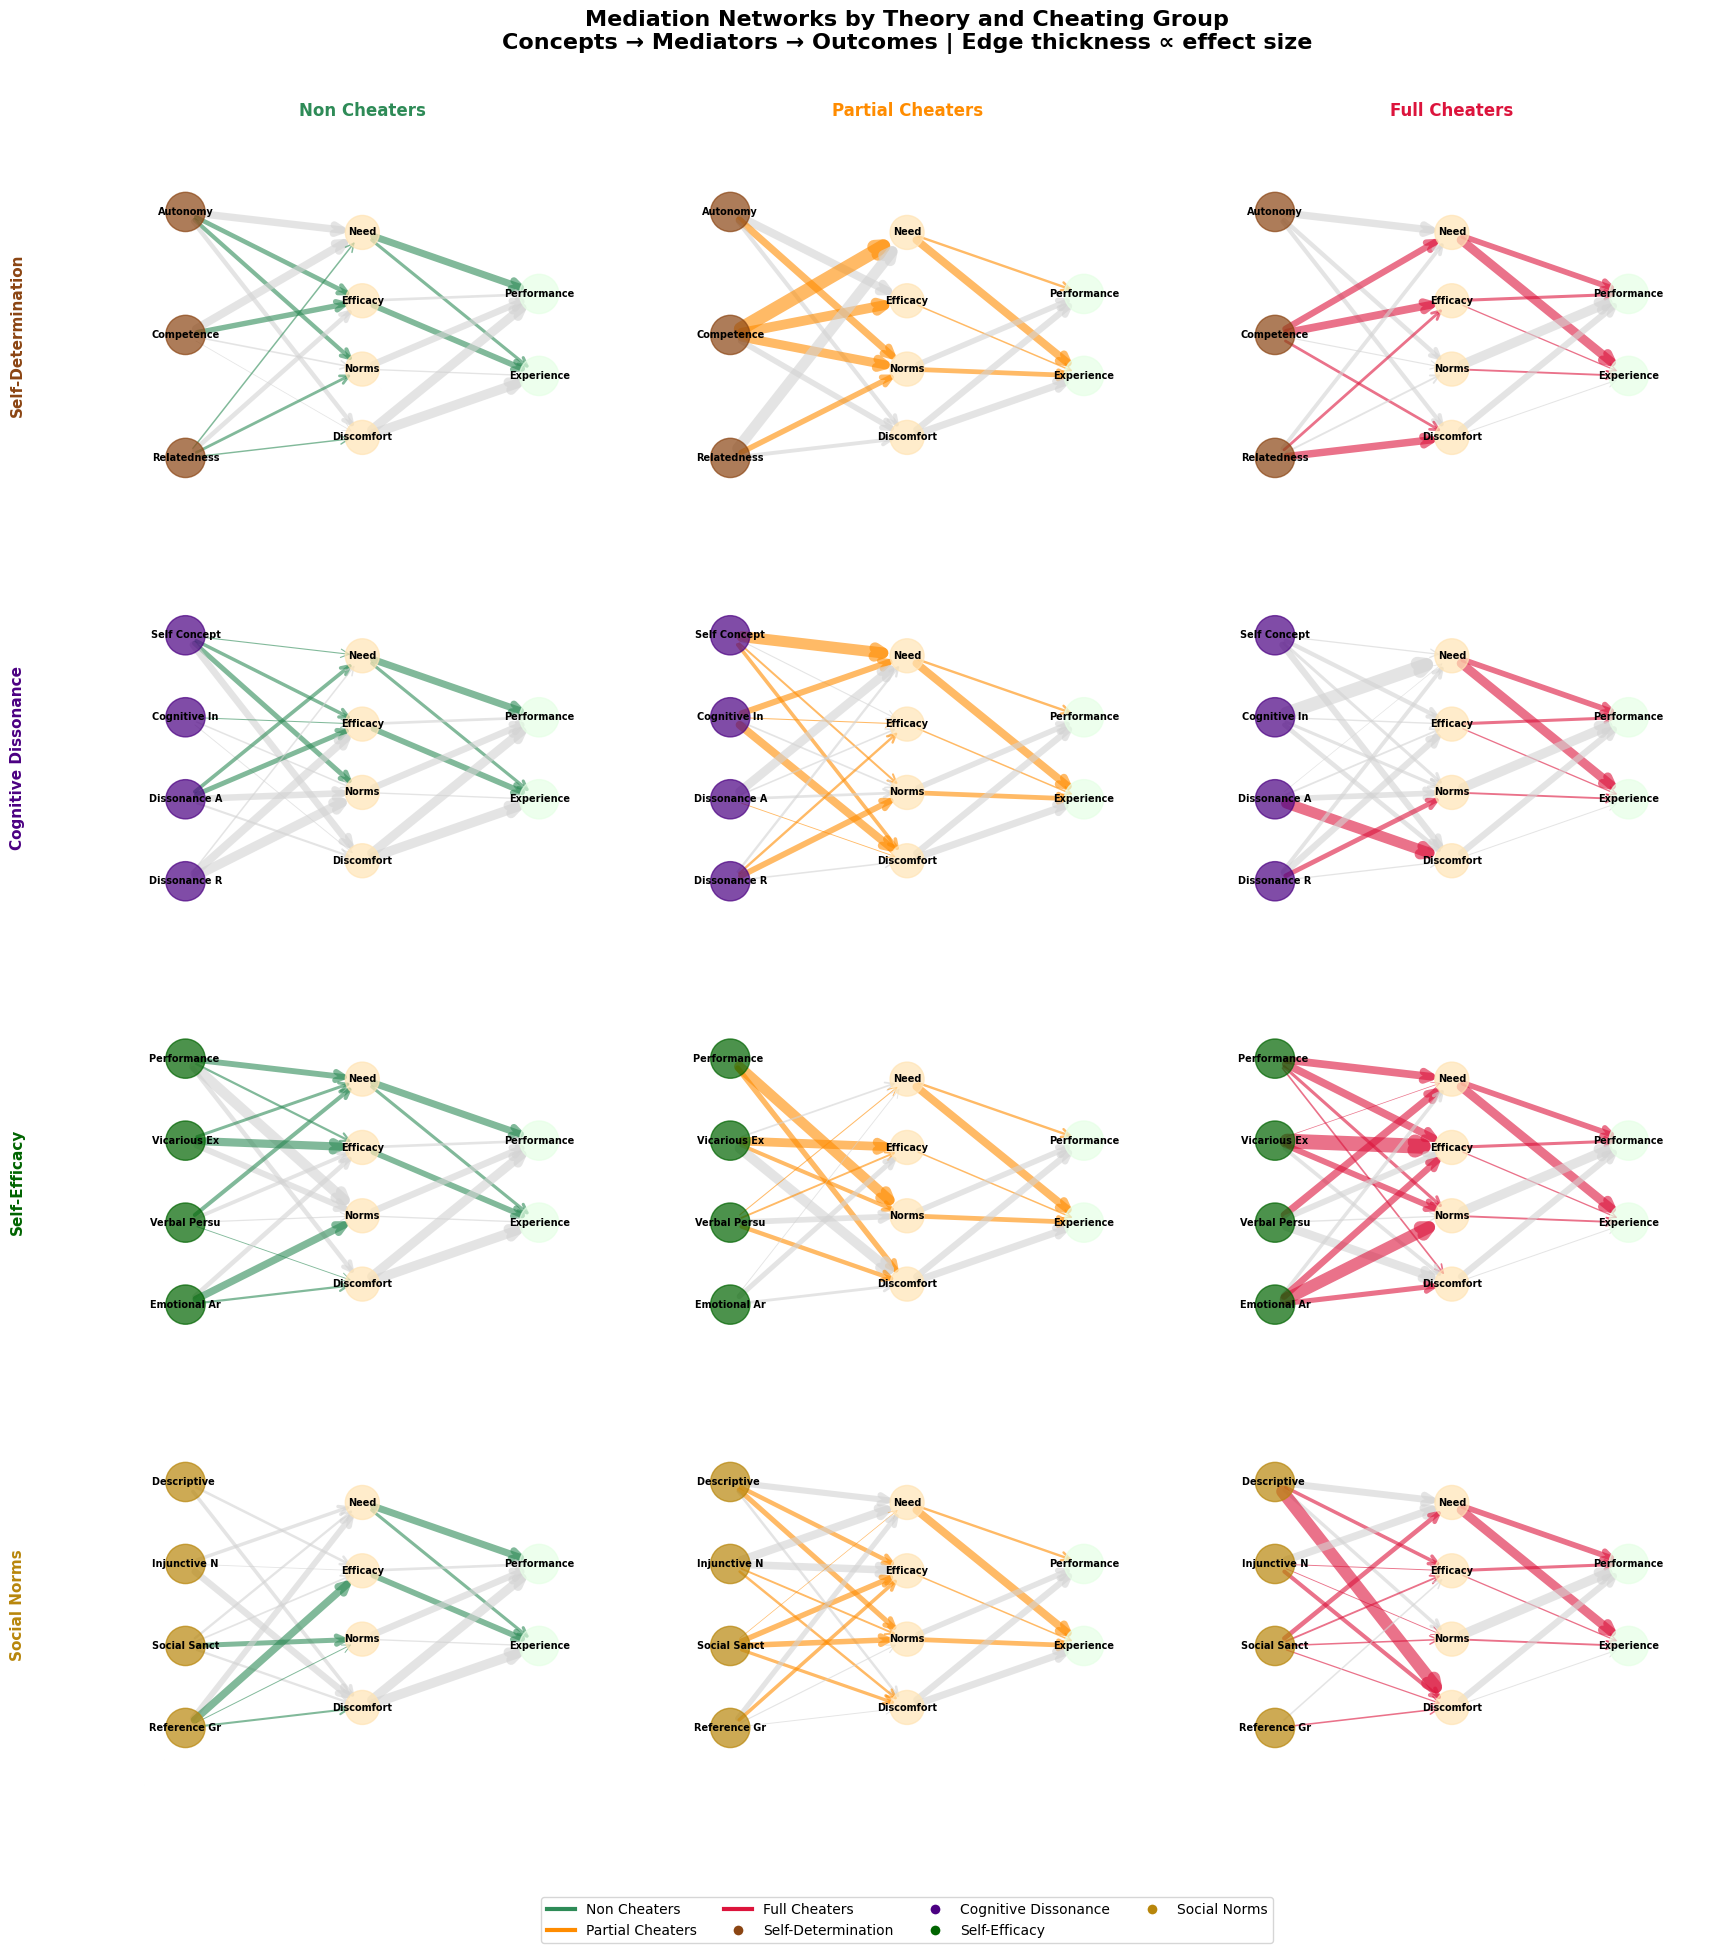

THEORY-SPECIFIC MEDIATION PATTERNS:

SELF-DETERMINATION:
  Non: 12 strong pathways
  Partial: 10 strong pathways
  Full: 12 strong pathways

COGNITIVE DISSONANCE:
  Non: 15 strong pathways
  Partial: 12 strong pathways
  Full: 16 strong pathways

SELF-EFFICACY:
  Non: 15 strong pathways
  Partial: 12 strong pathways
  Full: 16 strong pathways

SOCIAL NORMS:
  Non: 14 strong pathways
  Partial: 14 strong pathways
  Full: 15 strong pathways


In [27]:
# ============================================================================
# NETWORK VISUALIZATION: ALL CONCEPTS BY THEORY × CHEATING GROUPS
# ============================================================================

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def create_theory_mediation_networks(mediator_effects, perf_med, exp_med, 
                                   concepts, mediator_keys, threshold=0.03):
    """Create 4×3 network grid: theories × cheating groups"""
    
    # Theory groupings
    theories = {
        'Self-Determination': ['autonomy', 'competence', 'relatedness'],
        'Cognitive Dissonance': ['self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction'],
        'Self-Efficacy': ['performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal'],
        'Social Norms': ['descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification']
    }
    
    group_colors = {'Non': '#2E8B57', 'Partial': '#FF8C00', 'Full': '#DC143C'}
    theory_colors = {'Self-Determination': '#8B4513', 'Cognitive Dissonance': '#4B0082', 
                    'Self-Efficacy': '#006400', 'Social Norms': '#B8860B'}
    groups = ['Non', 'Partial', 'Full']
    
    # Create 4×3 subplot grid
    fig, axes = plt.subplots(4, 3, figsize=(18, 20))
    
    # Mediator abbreviations
    med_abbrev = {'Need Fulfillment': 'Need', 'Self Efficacy': 'Efficacy',
                 'Norm Perception': 'Norms', 'Discomfort': 'Discomfort'}
    
    for theory_idx, (theory_name, theory_concepts) in enumerate(theories.items()):
        for group_idx, group in enumerate(groups):
            ax = axes[theory_idx, group_idx]
            
            # Create graph
            G = nx.DiGraph()
            
            # Node positions
            positions = {}
            
            # Add concept nodes (left)
            valid_concepts = [c for c in theory_concepts if c in concepts]
            if not valid_concepts:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
                continue
                
            concept_y = np.linspace(0.8, 0.2, len(valid_concepts))
            for i, concept in enumerate(valid_concepts):
                short_name = concept.replace('_', ' ').title()[:12]
                G.add_node(short_name, layer='concept')
                positions[short_name] = (0.1, concept_y[i])
            
            # Add mediator nodes (middle)
            med_y = np.linspace(0.75, 0.25, len(mediator_keys))
            for i, med in enumerate(mediator_keys):
                med_short = med_abbrev[med]
                G.add_node(med_short, layer='mediator')
                positions[med_short] = (0.5, med_y[i])
            
            # Add outcome nodes (right)
            for i, outcome in enumerate(['Performance', 'Experience']):
                G.add_node(outcome, layer='outcome')
                positions[outcome] = (0.9, 0.6 - i*0.2)
            
            # Add edges with weights
            edge_weights, edge_colors = [], []
            
            # Concept → Mediator edges
            for concept in valid_concepts:
                concept_idx = concepts.index(concept)
                short_name = concept.replace('_', ' ').title()[:12]
                
                for med_idx, med in enumerate(mediator_keys):
                    med_short = med_abbrev[med]
                    effect = mediator_effects[med][0, concept_idx, group_idx]
                    
                    if abs(effect) > threshold:
                        G.add_edge(short_name, med_short, weight=abs(effect))
                        edge_weights.append(abs(effect) * 15)
                        edge_colors.append(group_colors[group] if effect > 0 else 'lightgray')
            
            # Mediator → Outcome edges
            for med_idx, med in enumerate(mediator_keys):
                med_short = med_abbrev[med]
                
                # To Performance
                perf_effect = perf_med[0, med_idx, group_idx]
                if abs(perf_effect) > threshold:
                    G.add_edge(med_short, 'Performance', weight=abs(perf_effect))
                    edge_weights.append(abs(perf_effect) * 3)
                    edge_colors.append(group_colors[group] if perf_effect > 0 else 'lightgray')
                
                # To Experience
                exp_effect = exp_med[0, med_idx, group_idx]
                if abs(exp_effect) > threshold:
                    G.add_edge(med_short, 'Experience', weight=abs(exp_effect))
                    edge_weights.append(abs(exp_effect) * 20)
                    edge_colors.append(group_colors[group] if exp_effect > 0 else 'lightgray')
            
            # Draw network
            node_colors = []
            node_sizes = []
            for node in G.nodes():
                layer = G.nodes[node]['layer']
                if layer == 'concept':
                    node_colors.append(theory_colors[theory_name])
                    node_sizes.append(800)
                elif layer == 'mediator':
                    node_colors.append('#FFE4B5')
                    node_sizes.append(600)
                else:
                    node_colors.append('#E6FFE6')
                    node_sizes.append(800)
            
            # Draw elements
            nx.draw_networkx_nodes(G, positions, node_color=node_colors, 
                                 node_size=node_sizes, alpha=0.7, ax=ax)
            
            if edge_weights:
                nx.draw_networkx_edges(G, positions, width=edge_weights, 
                                     edge_color=edge_colors, alpha=0.6, 
                                     arrowsize=15, arrowstyle='->', ax=ax)
            
            nx.draw_networkx_labels(G, positions, font_size=7, font_weight='bold', ax=ax)
            
            # Titles
            if theory_idx == 0:  # Top row
                ax.set_title(f'{group} Cheaters', fontsize=12, fontweight='bold', 
                           color=group_colors[group], pad=10)
            if group_idx == 0:  # Left column
                ax.text(-0.15, 0.5, theory_name, rotation=90, transform=ax.transAxes,
                       fontsize=11, fontweight='bold', ha='center', va='center',
                       color=theory_colors[theory_name])
            
            ax.axis('off')
            ax.set_xlim(-0.1, 1.1)
            ax.set_ylim(0, 1)
    
    # Overall title and legend
    fig.suptitle('Mediation Networks by Theory and Cheating Group\n' + 
                'Concepts → Mediators → Outcomes | Edge thickness ∝ effect size',
                fontsize=16, fontweight='bold', y=0.98)
    
    # Legends
    from matplotlib.lines import Line2D
    group_legend = [Line2D([0], [0], color=color, lw=3, label=f'{group} Cheaters') 
                   for group, color in group_colors.items()]
    theory_legend = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                           markersize=8, label=theory) 
                    for theory, color in theory_colors.items()]
    
    fig.legend(handles=group_legend + theory_legend, 
              loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01), fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=0.95)
    plt.show()
    
    # Summary statistics
    print("THEORY-SPECIFIC MEDIATION PATTERNS:")
    print("="*40)
    
    for theory_name, theory_concepts in theories.items():
        print(f"\n{theory_name.upper()}:")
        valid_concepts = [c for c in theory_concepts if c in concepts]
        
        # Count strong pathways by group
        for group_idx, group in enumerate(groups):
            strong_paths = 0
            for concept in valid_concepts:
                concept_idx = concepts.index(concept)
                for med_idx, med in enumerate(mediator_keys):
                    path_a = mediator_effects[med][0, concept_idx, group_idx]
                    path_b_perf = perf_med[0, med_idx, group_idx] 
                    path_b_exp = exp_med[0, med_idx, group_idx]
                    
                    if abs(path_a * path_b_perf) > 0.02 or abs(path_a * path_b_exp) > 0.01:
                        strong_paths += 1
            
            print(f"  {group}: {strong_paths} strong pathways")

# Execute visualization
create_theory_mediation_networks(mediator_effects, perf_med, exp_med, 
                                concepts, mediator_keys)